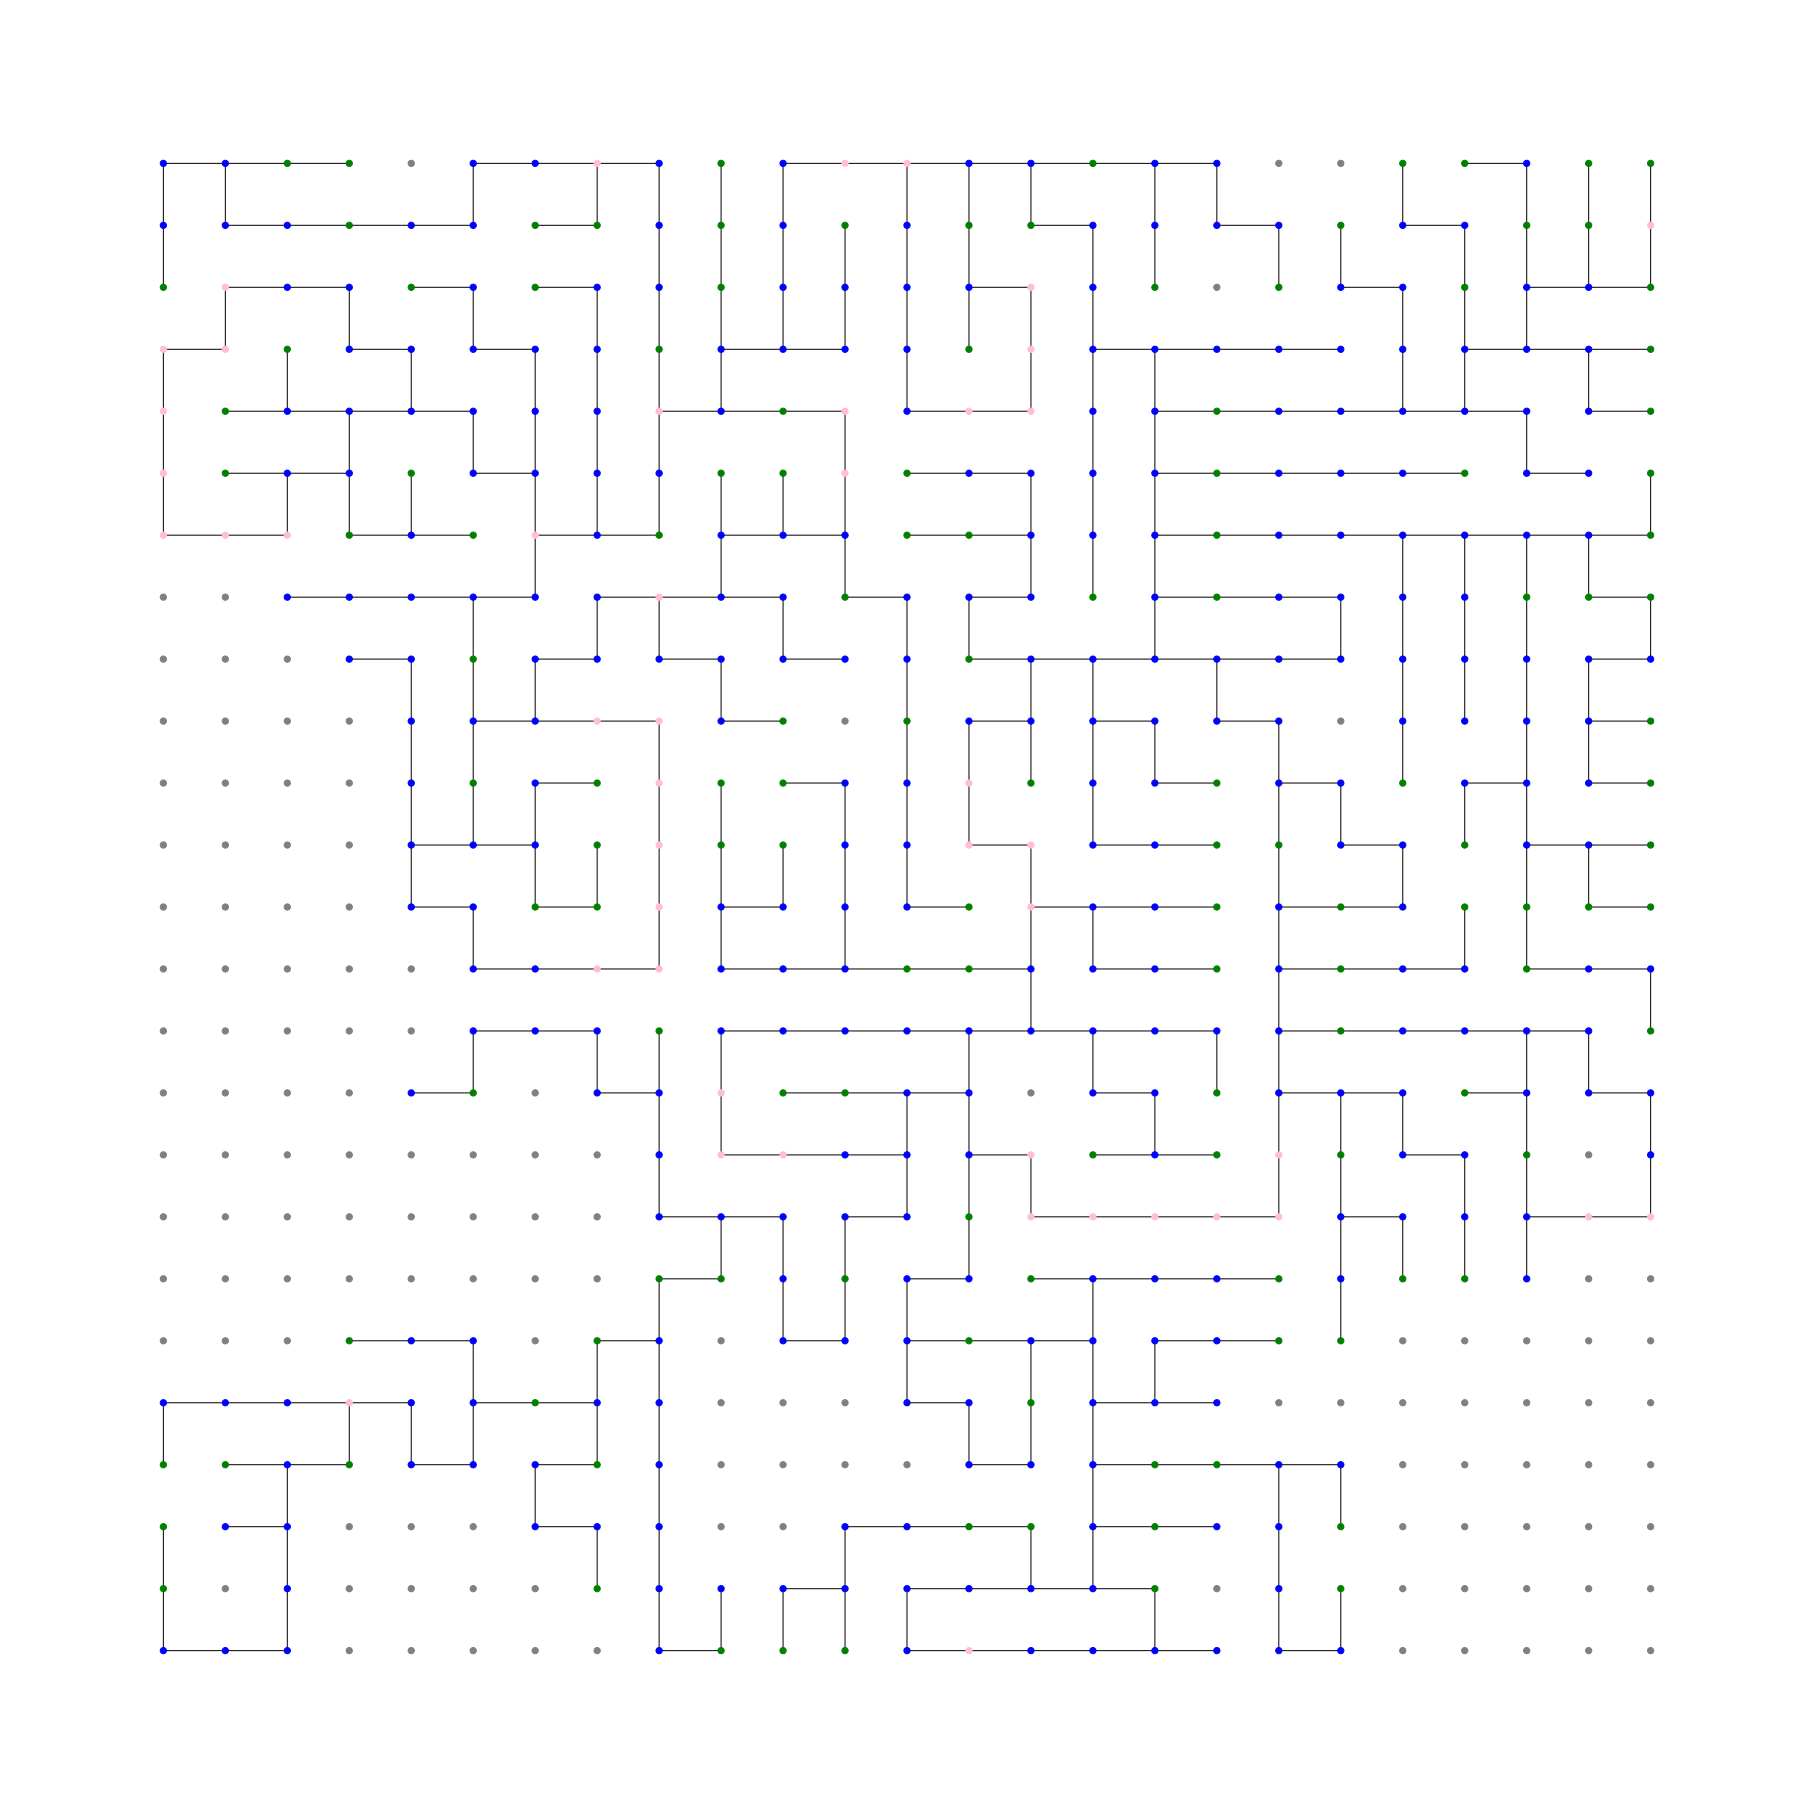

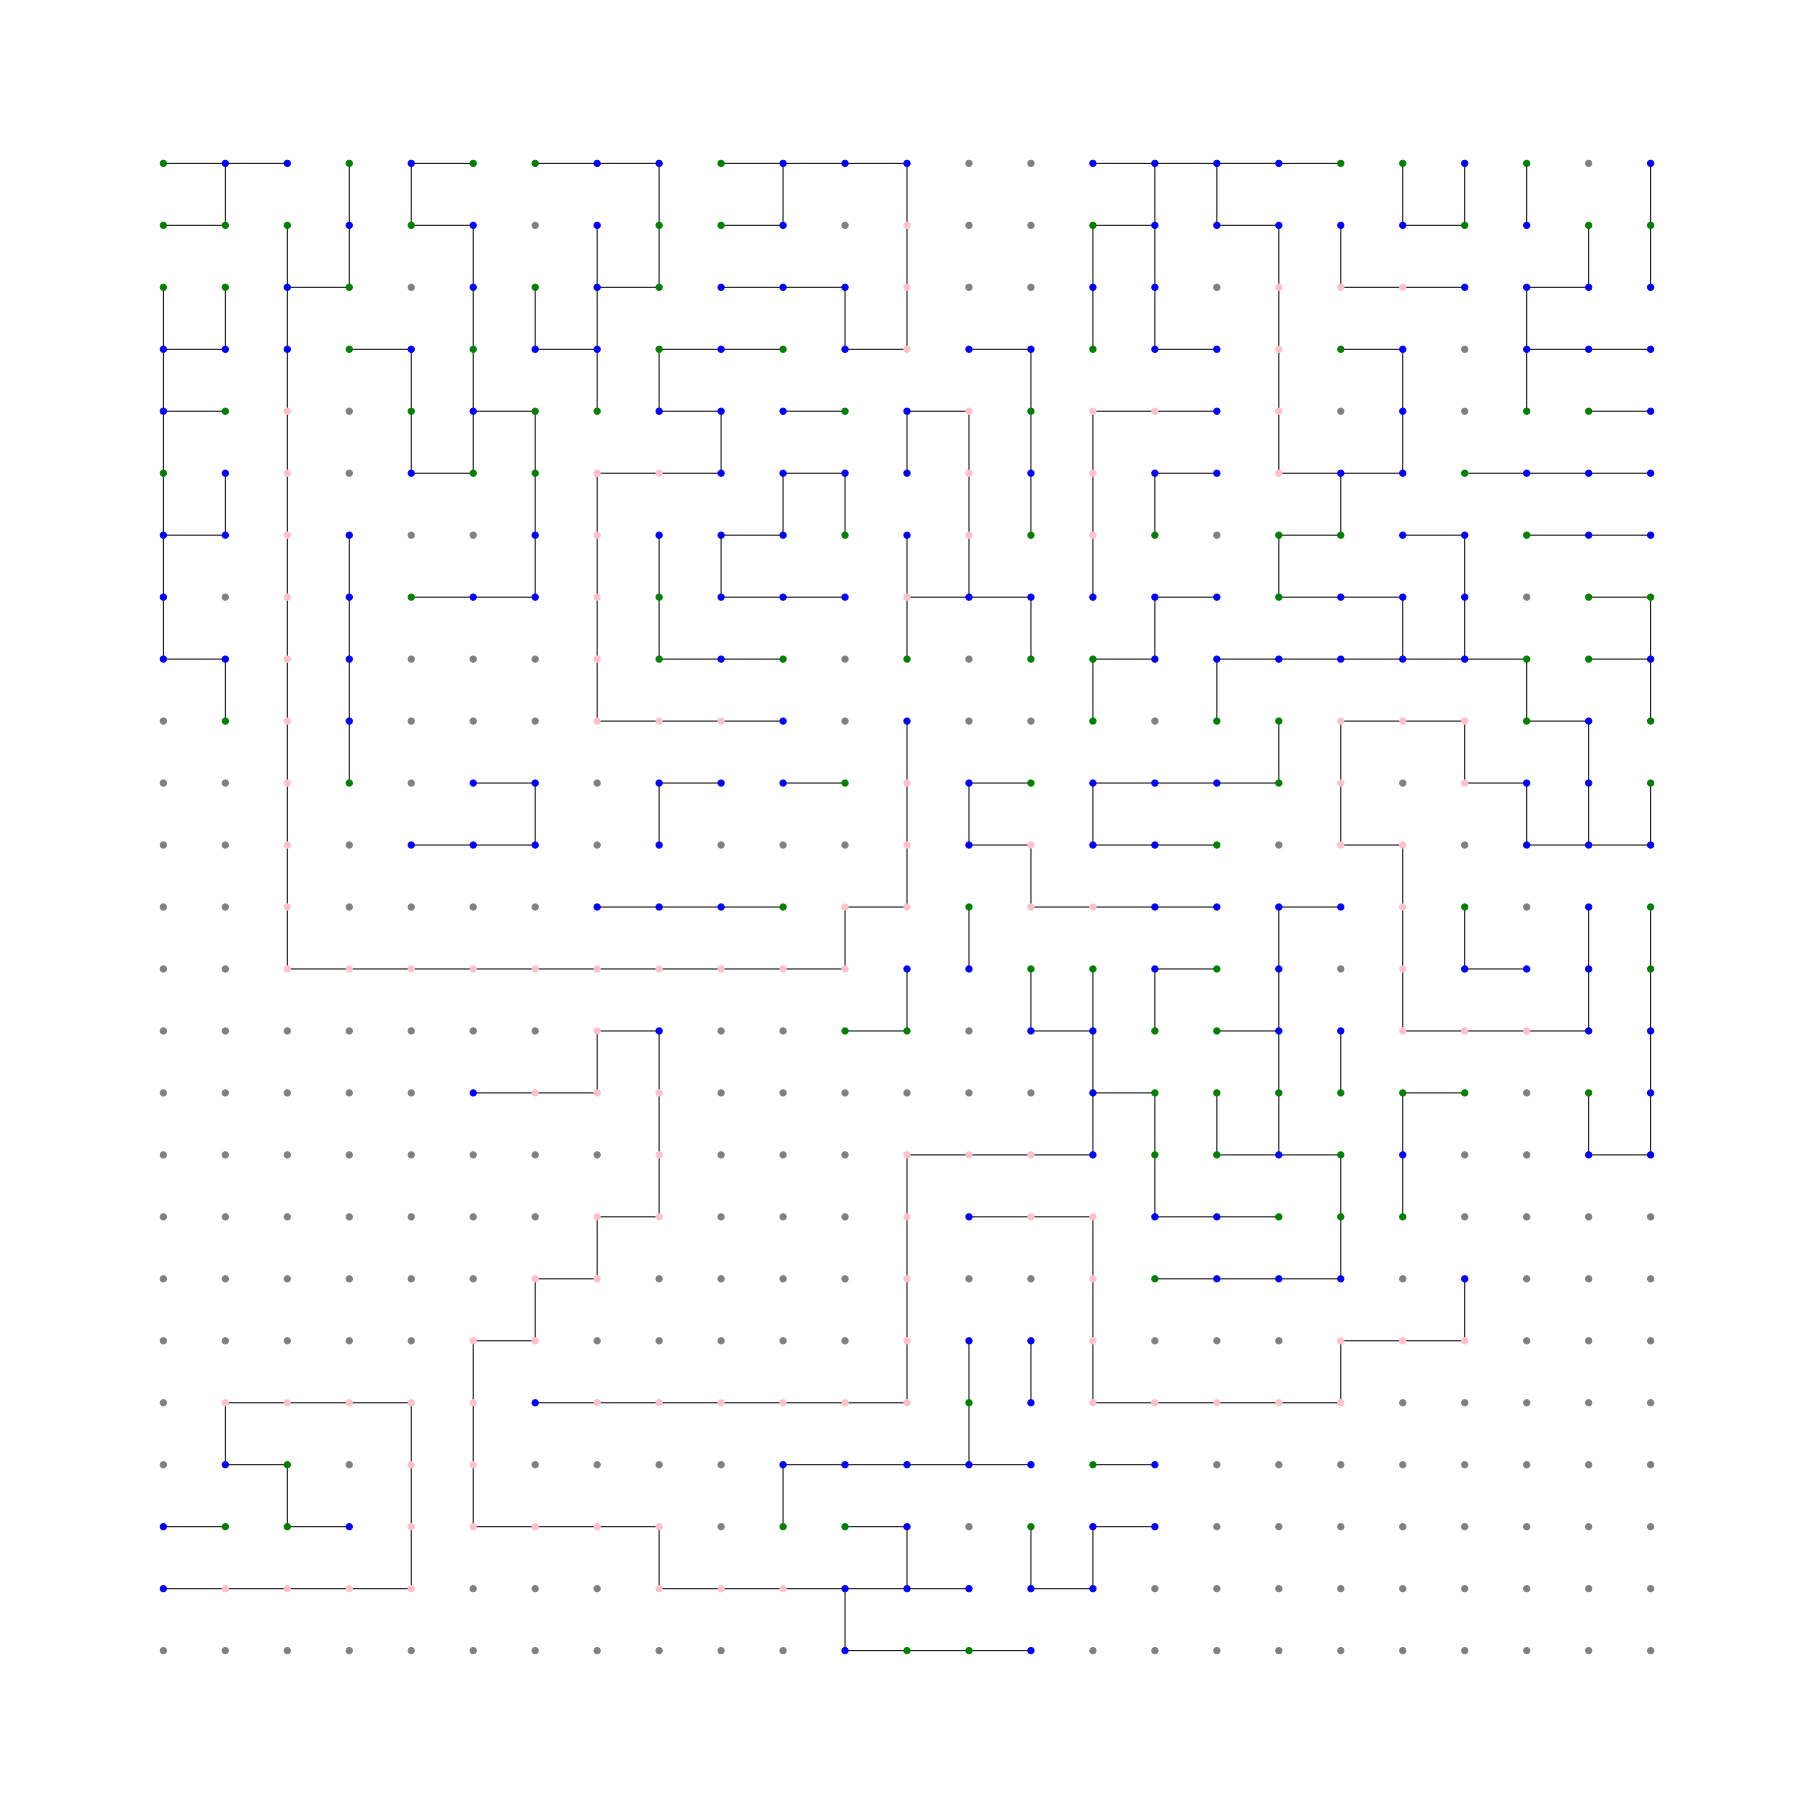

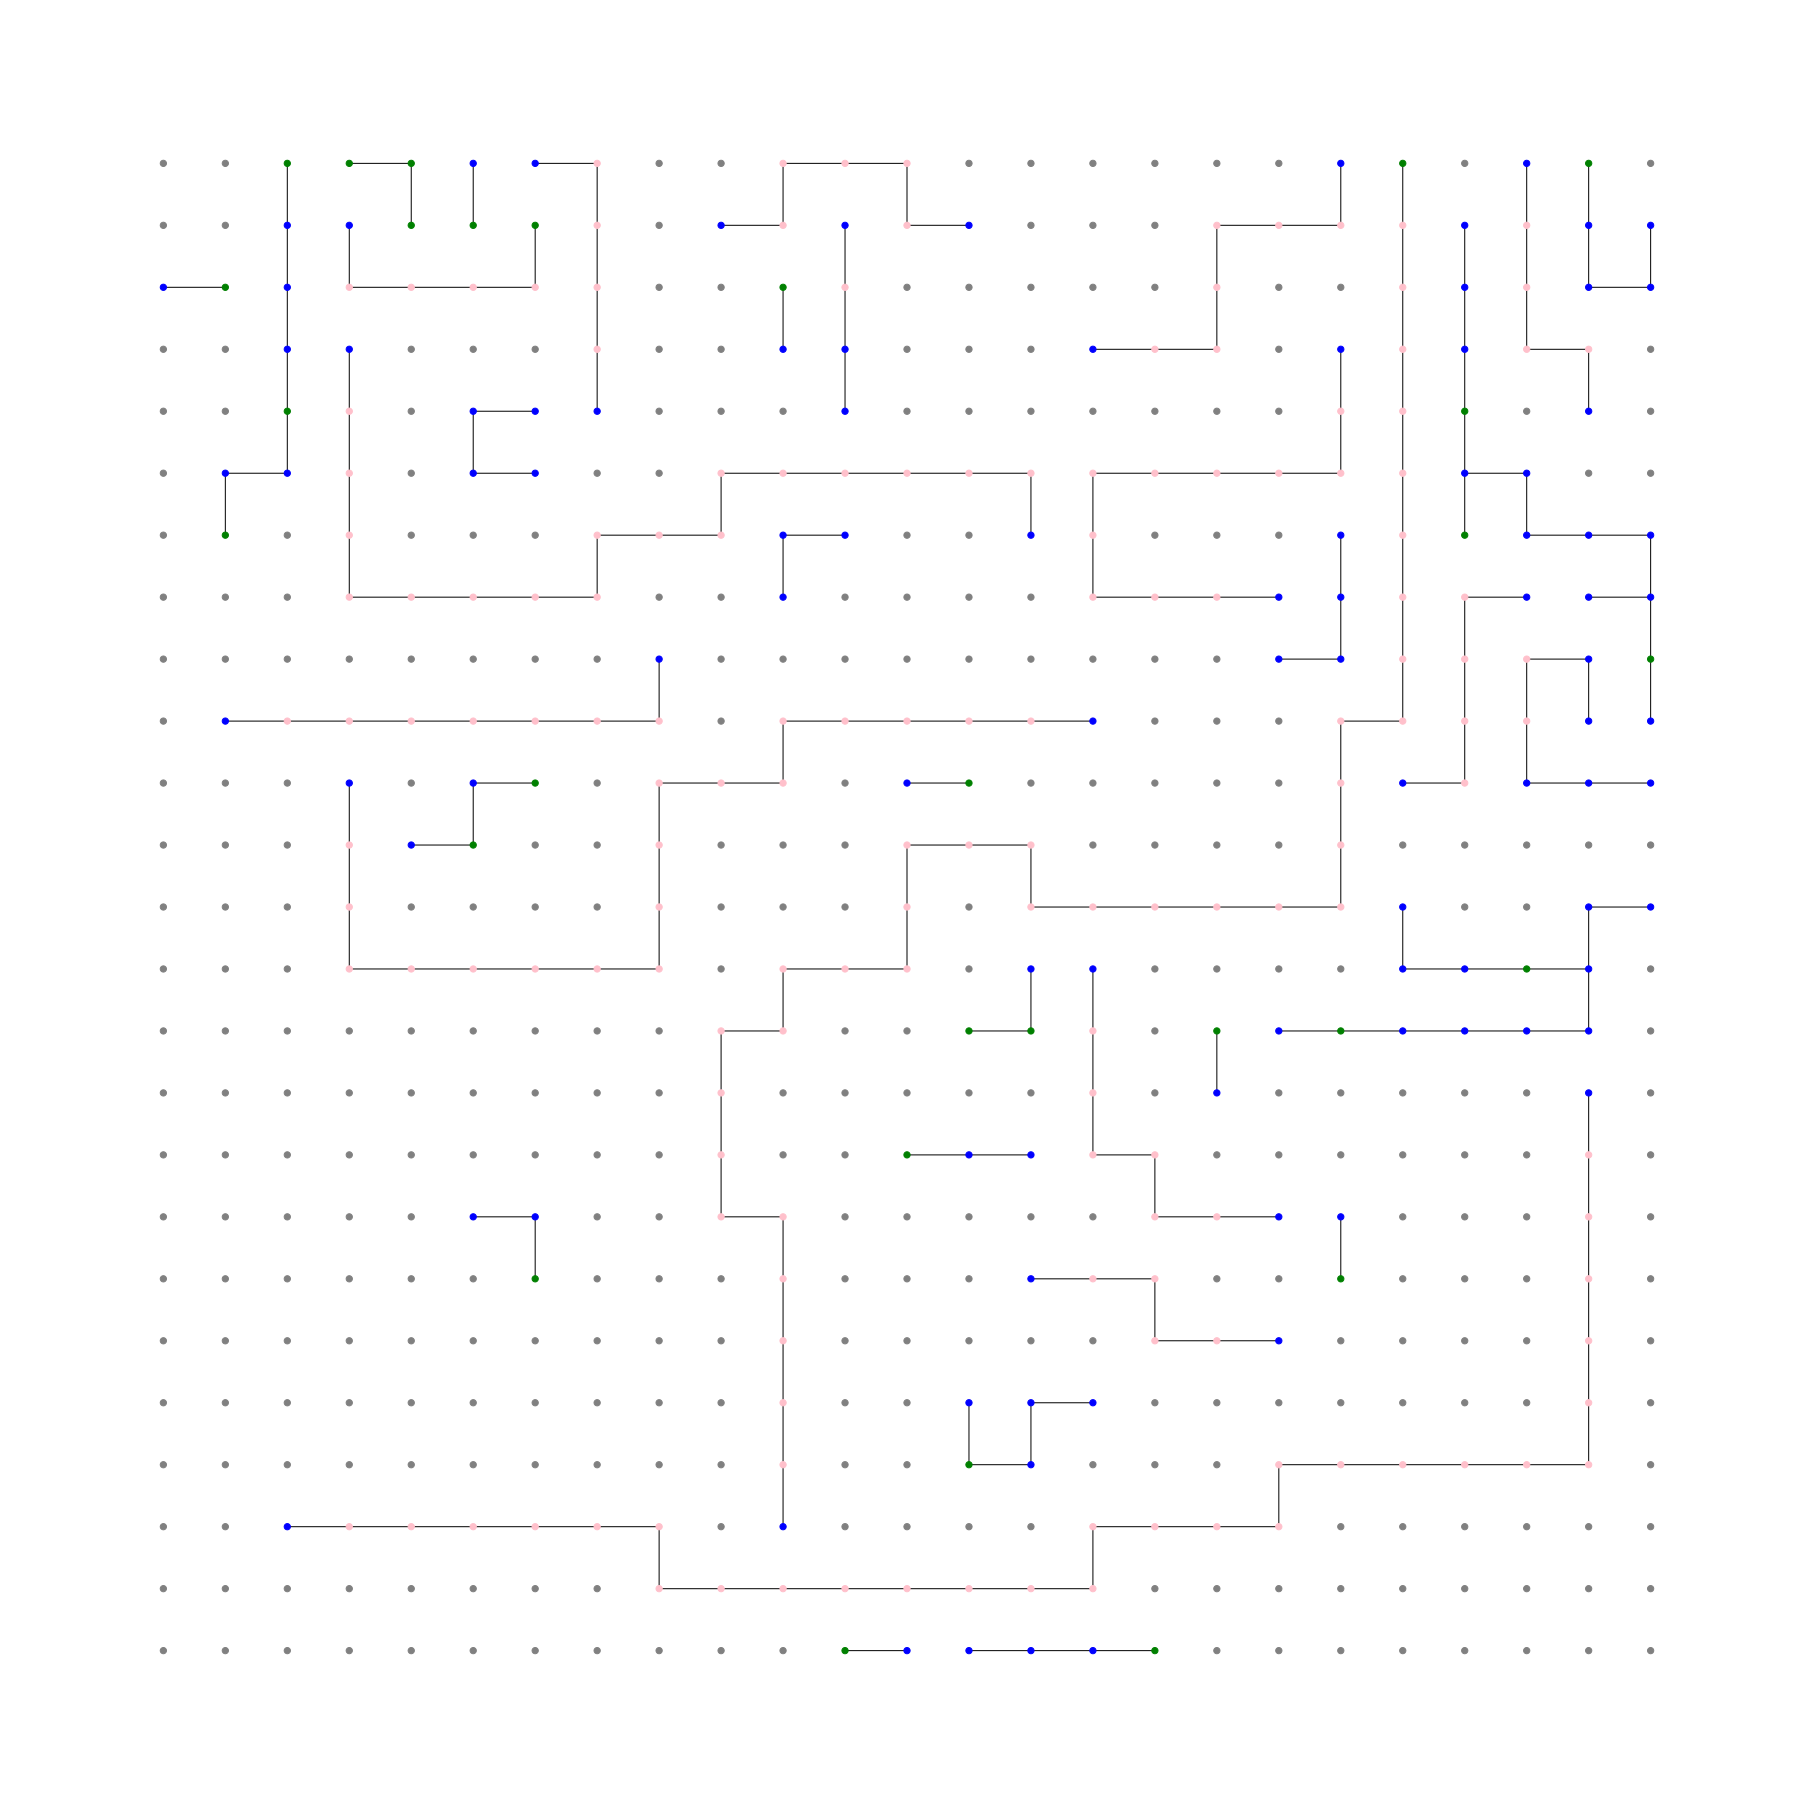

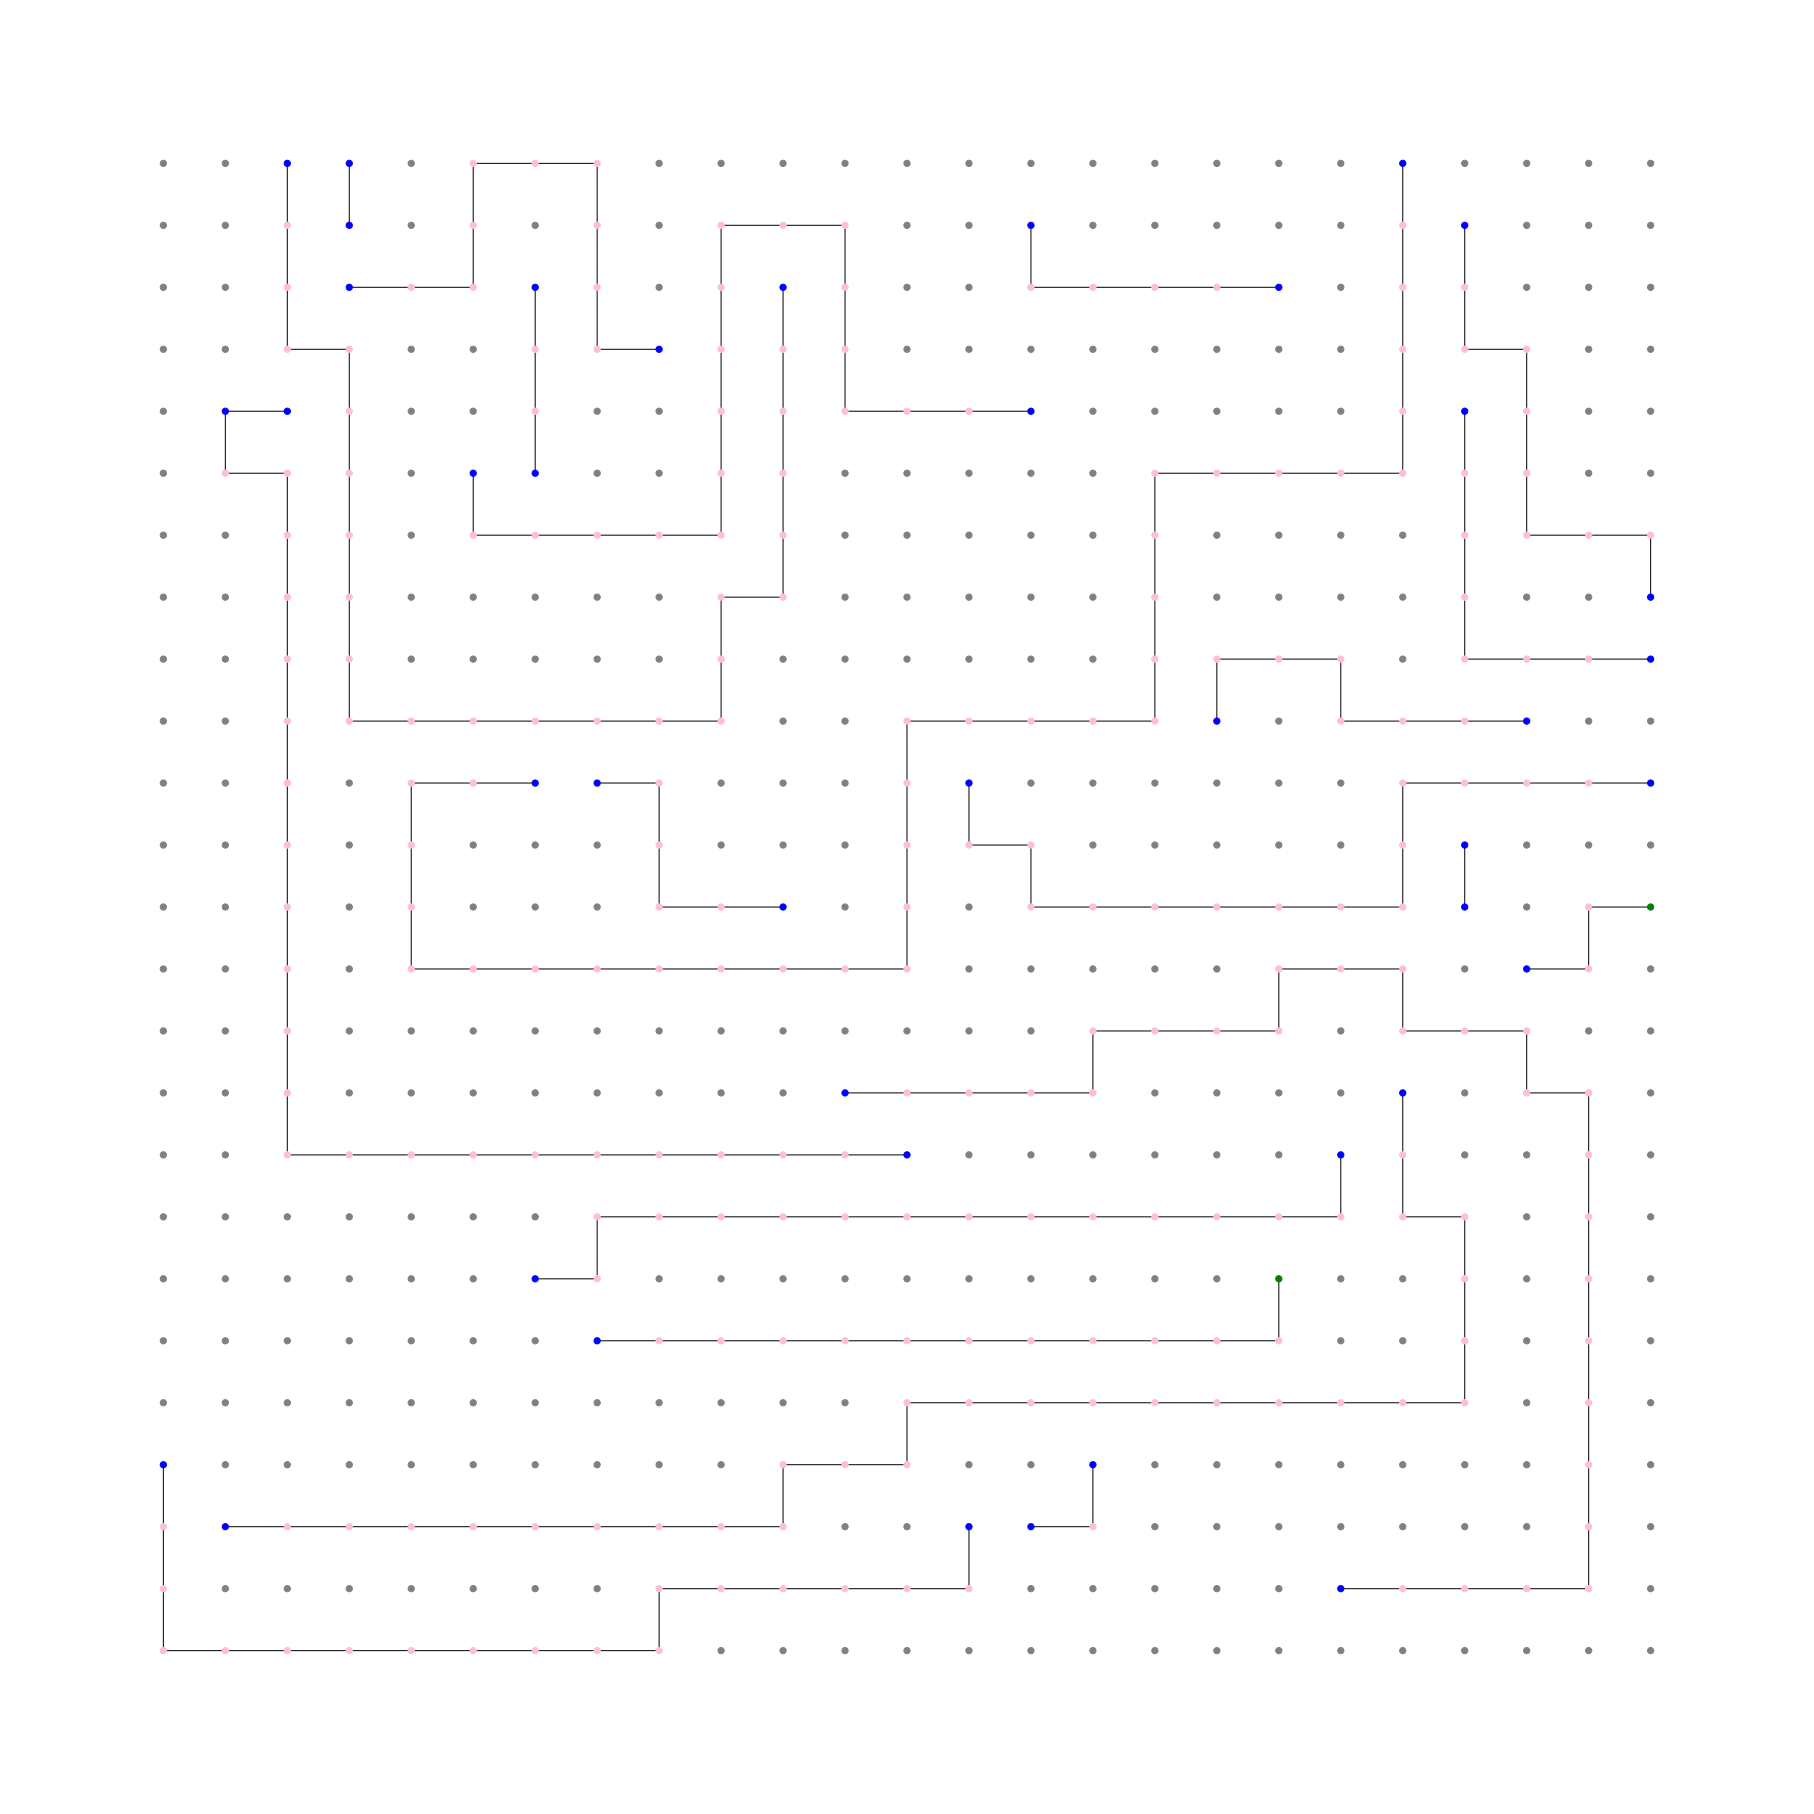

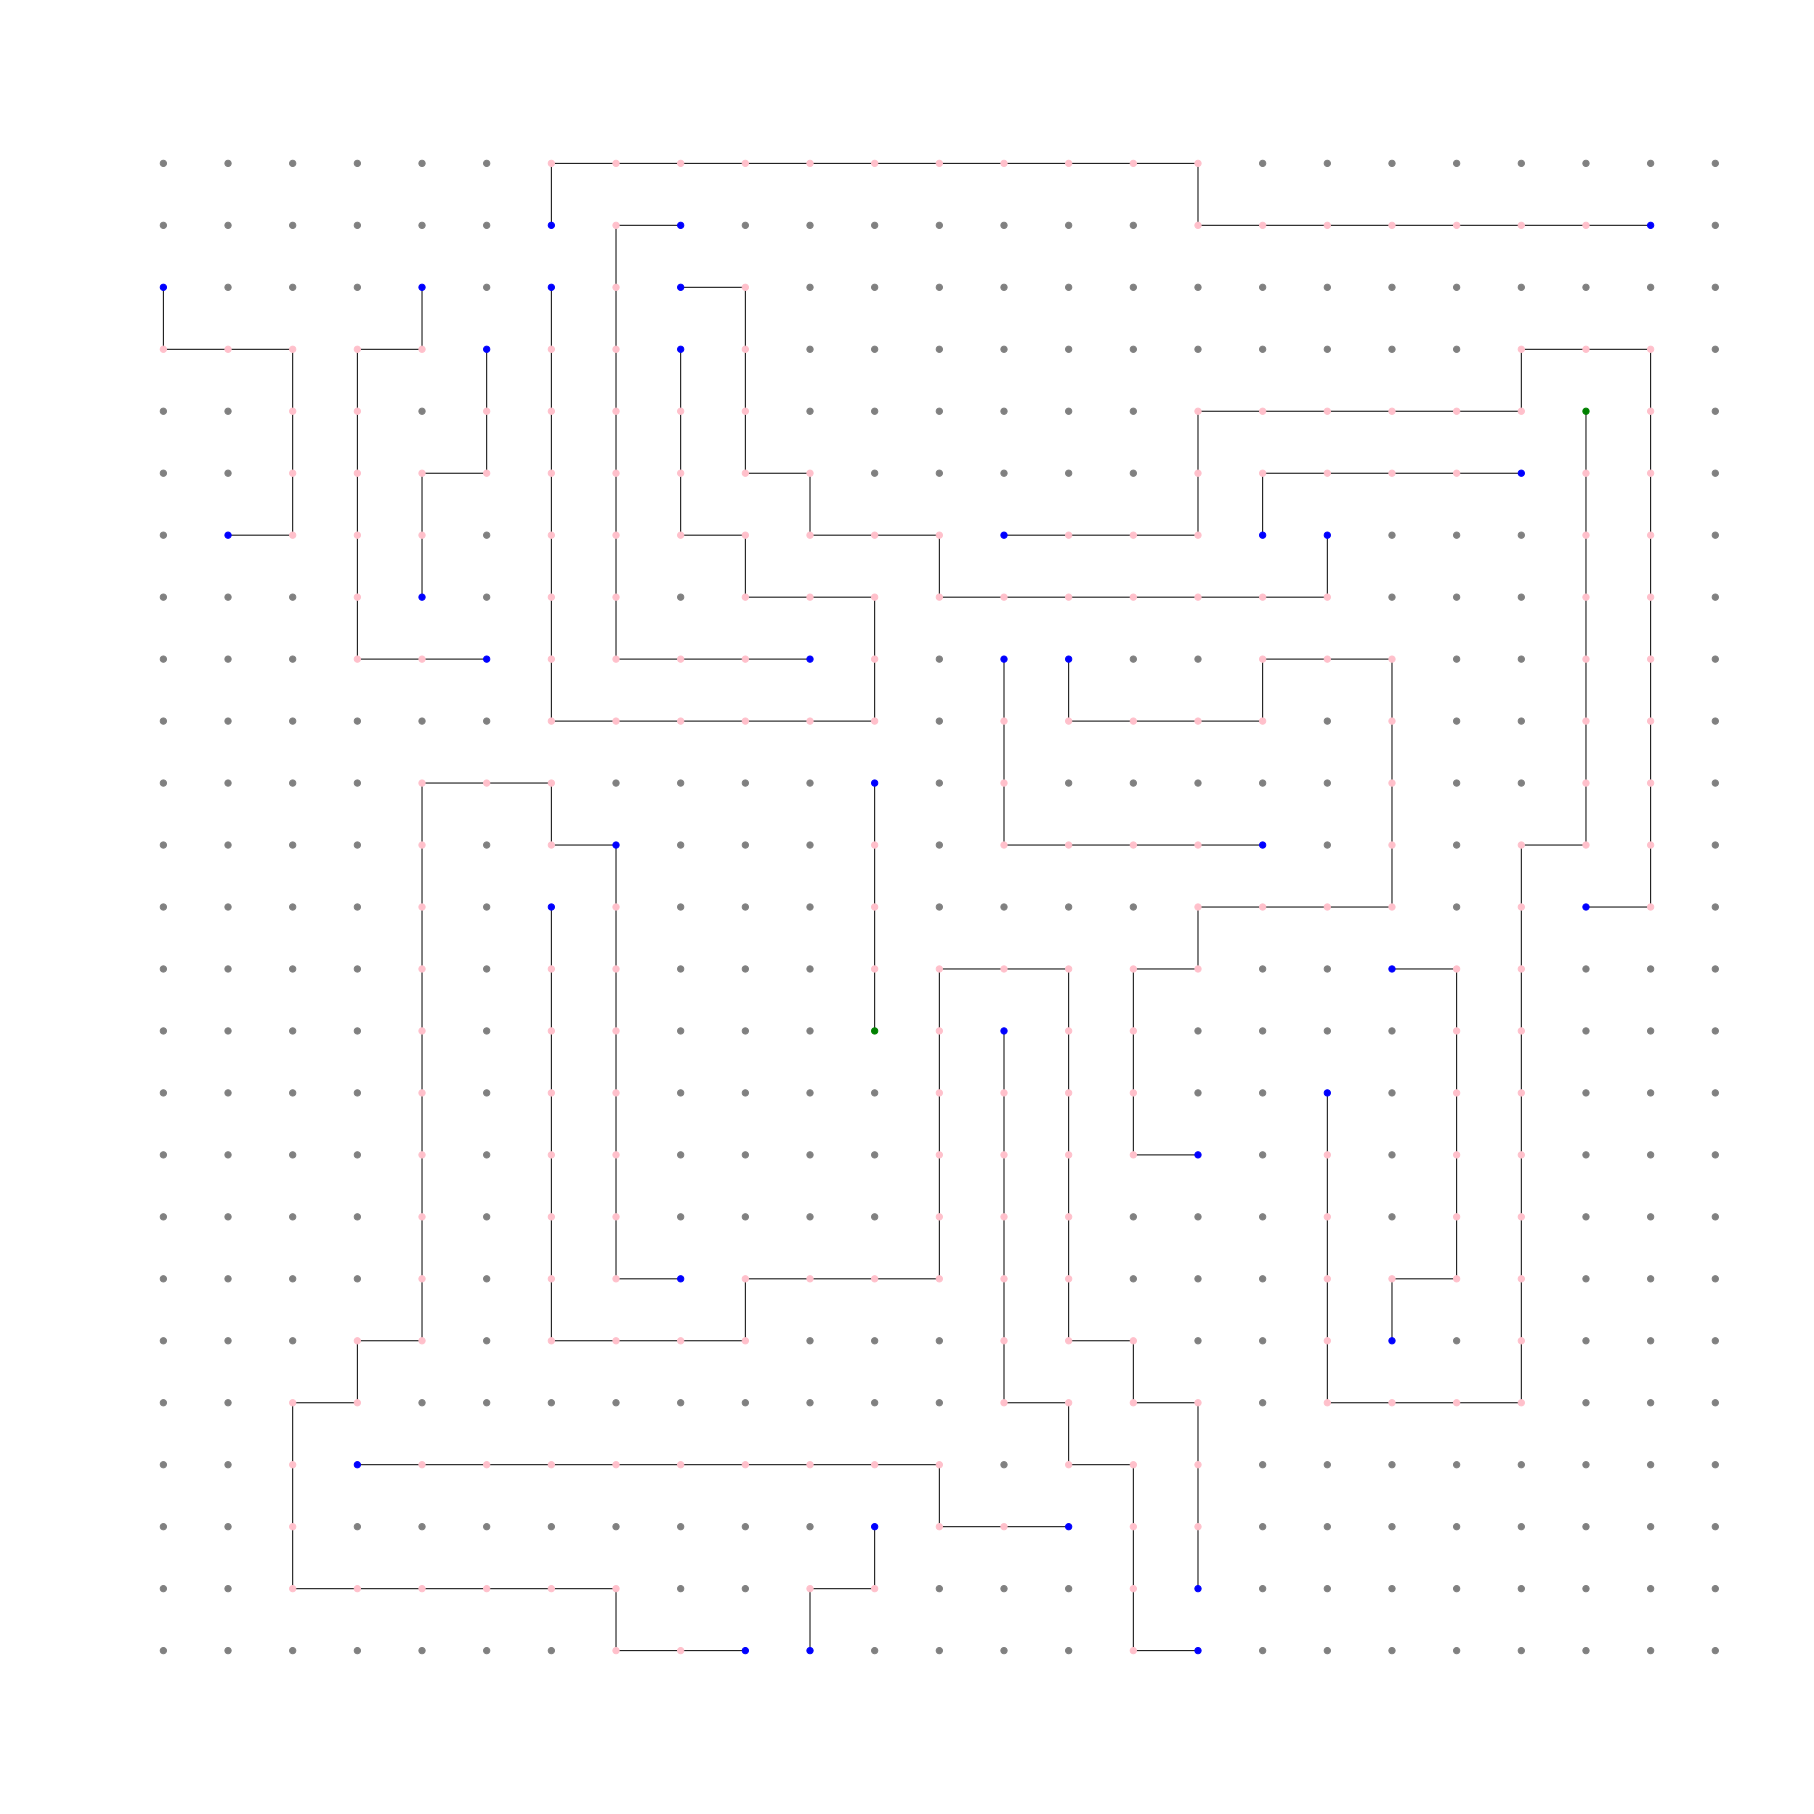

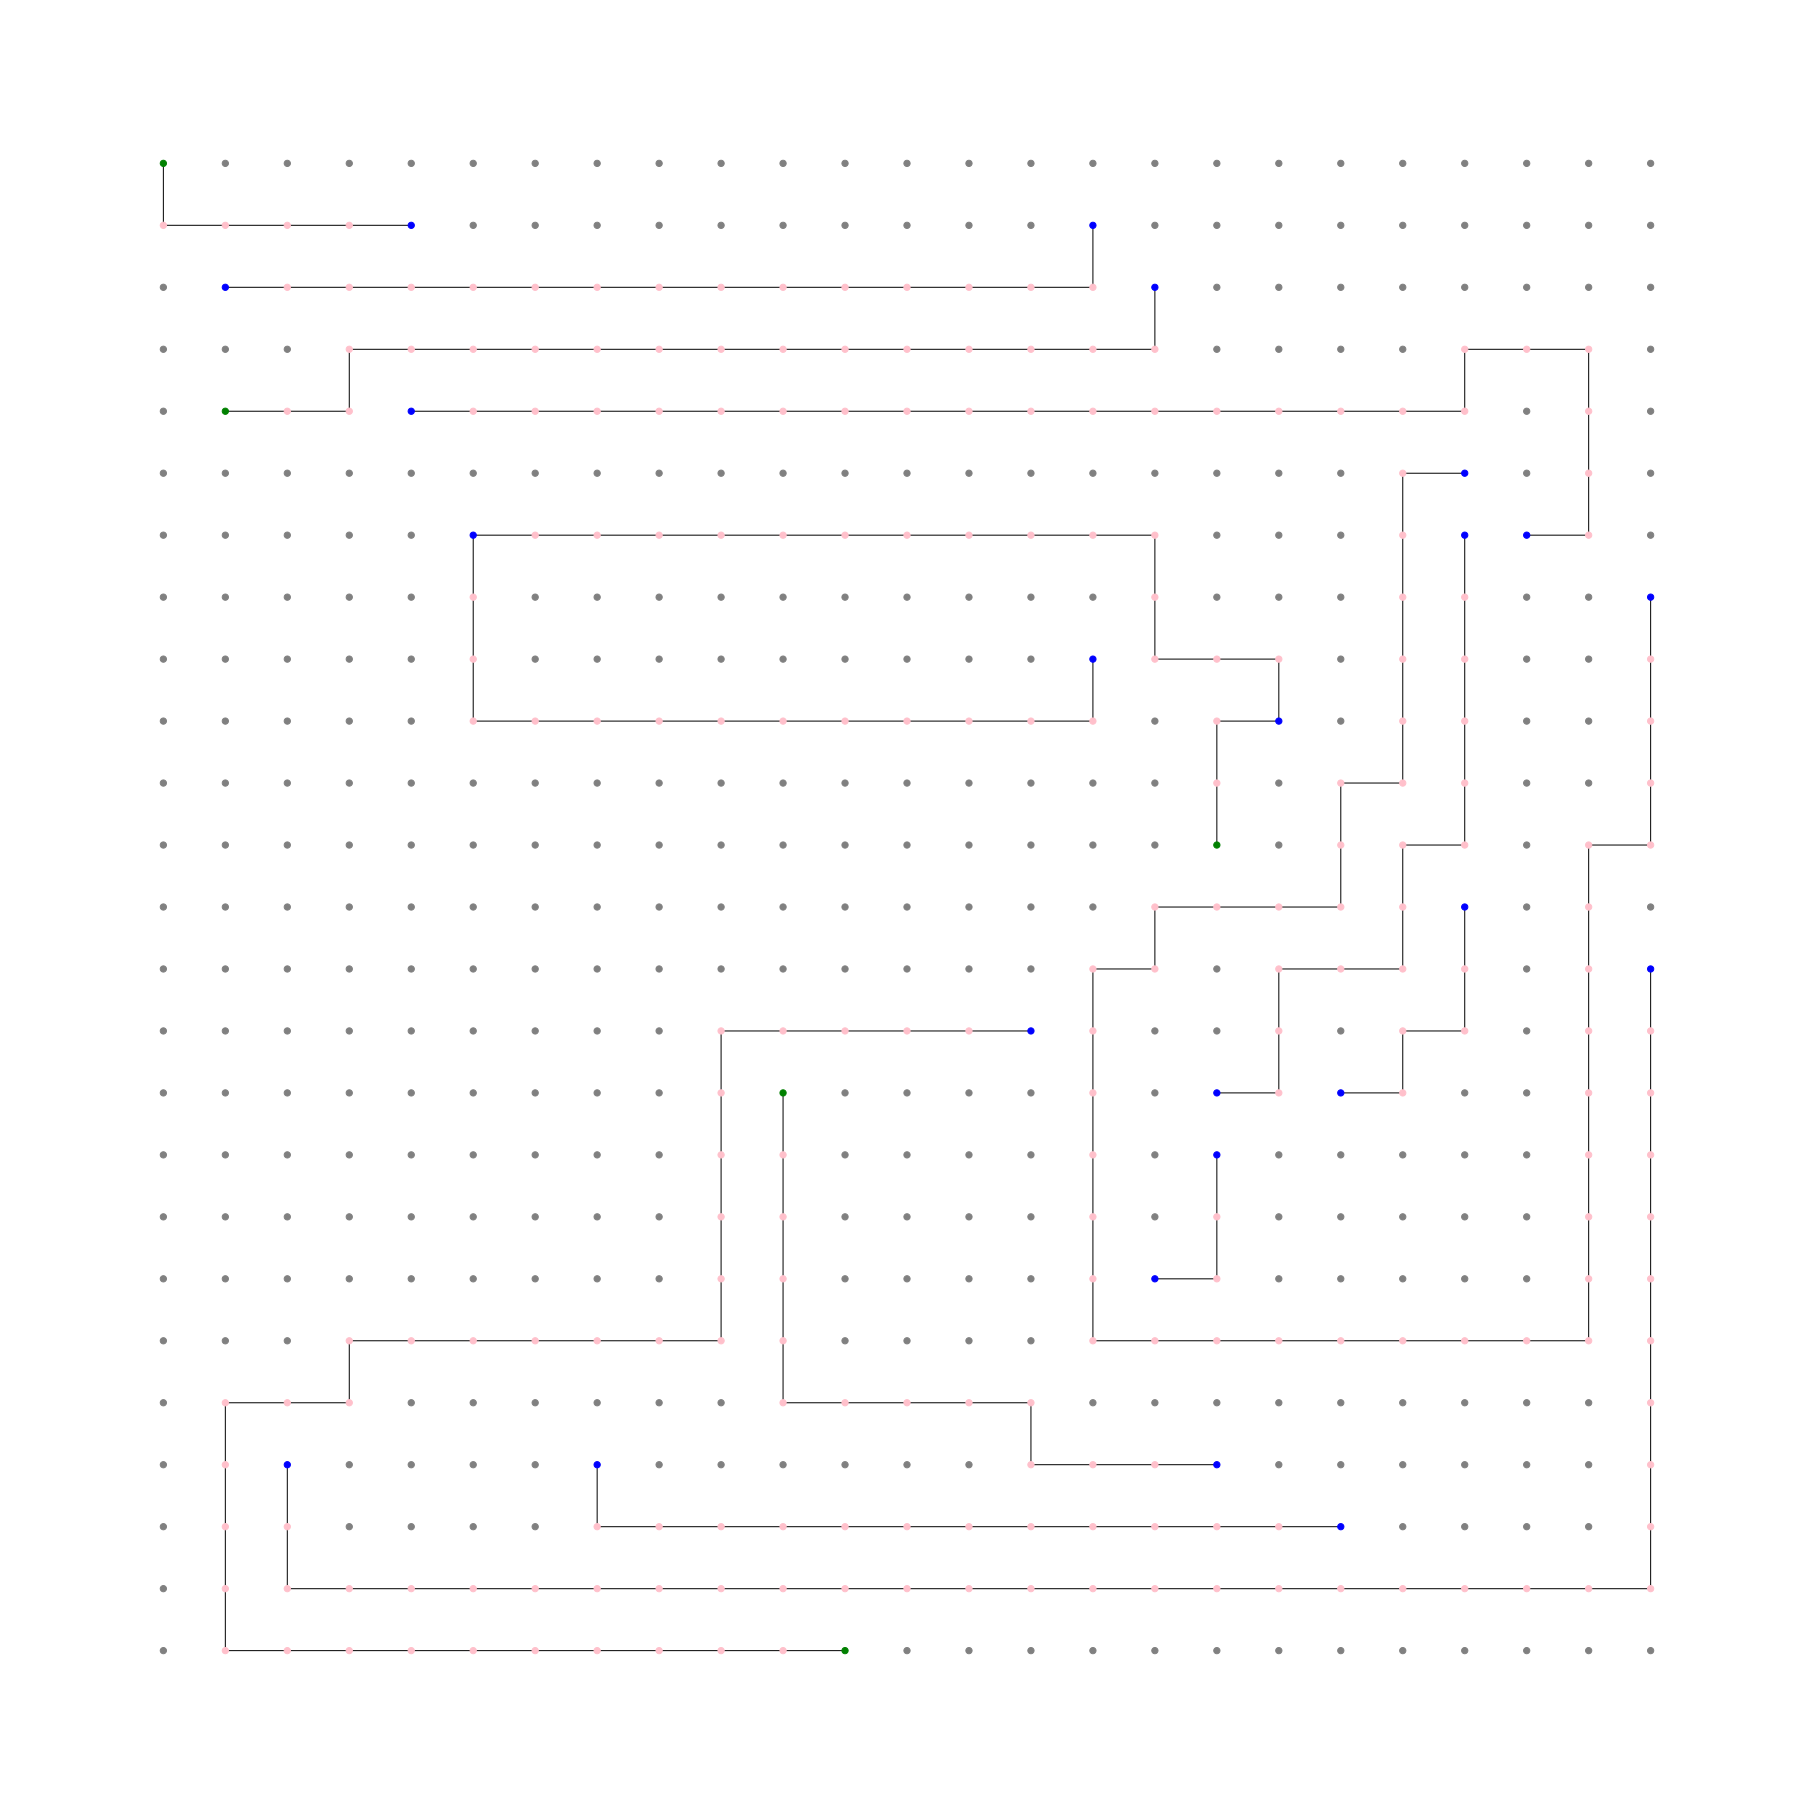

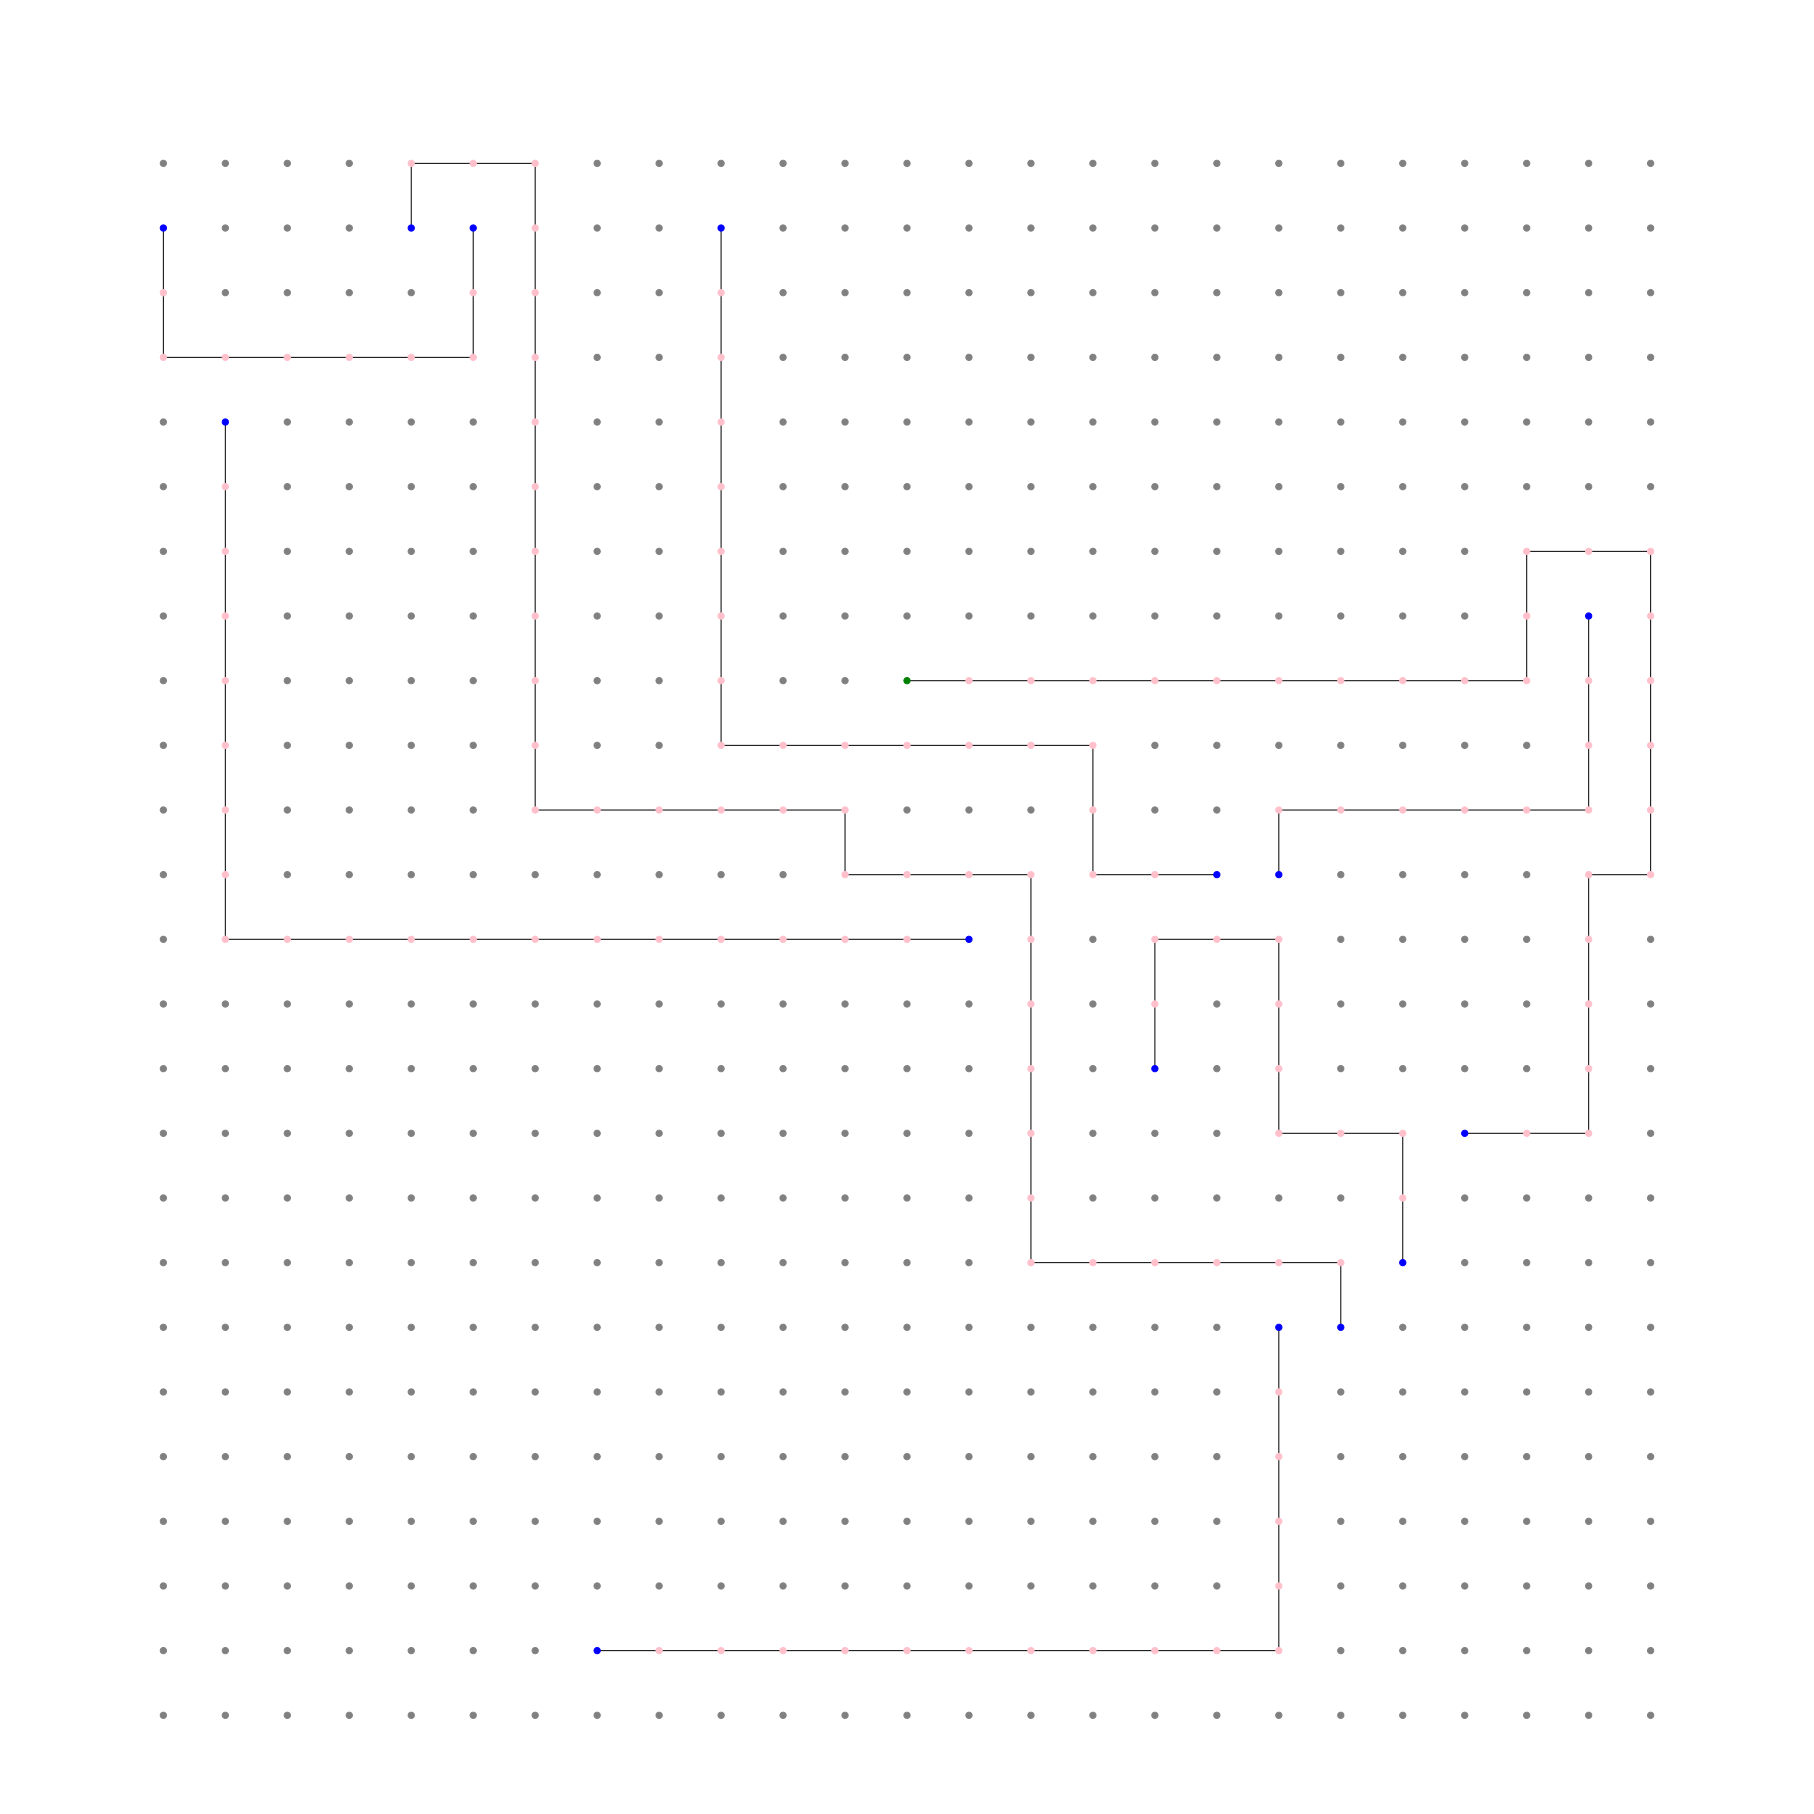

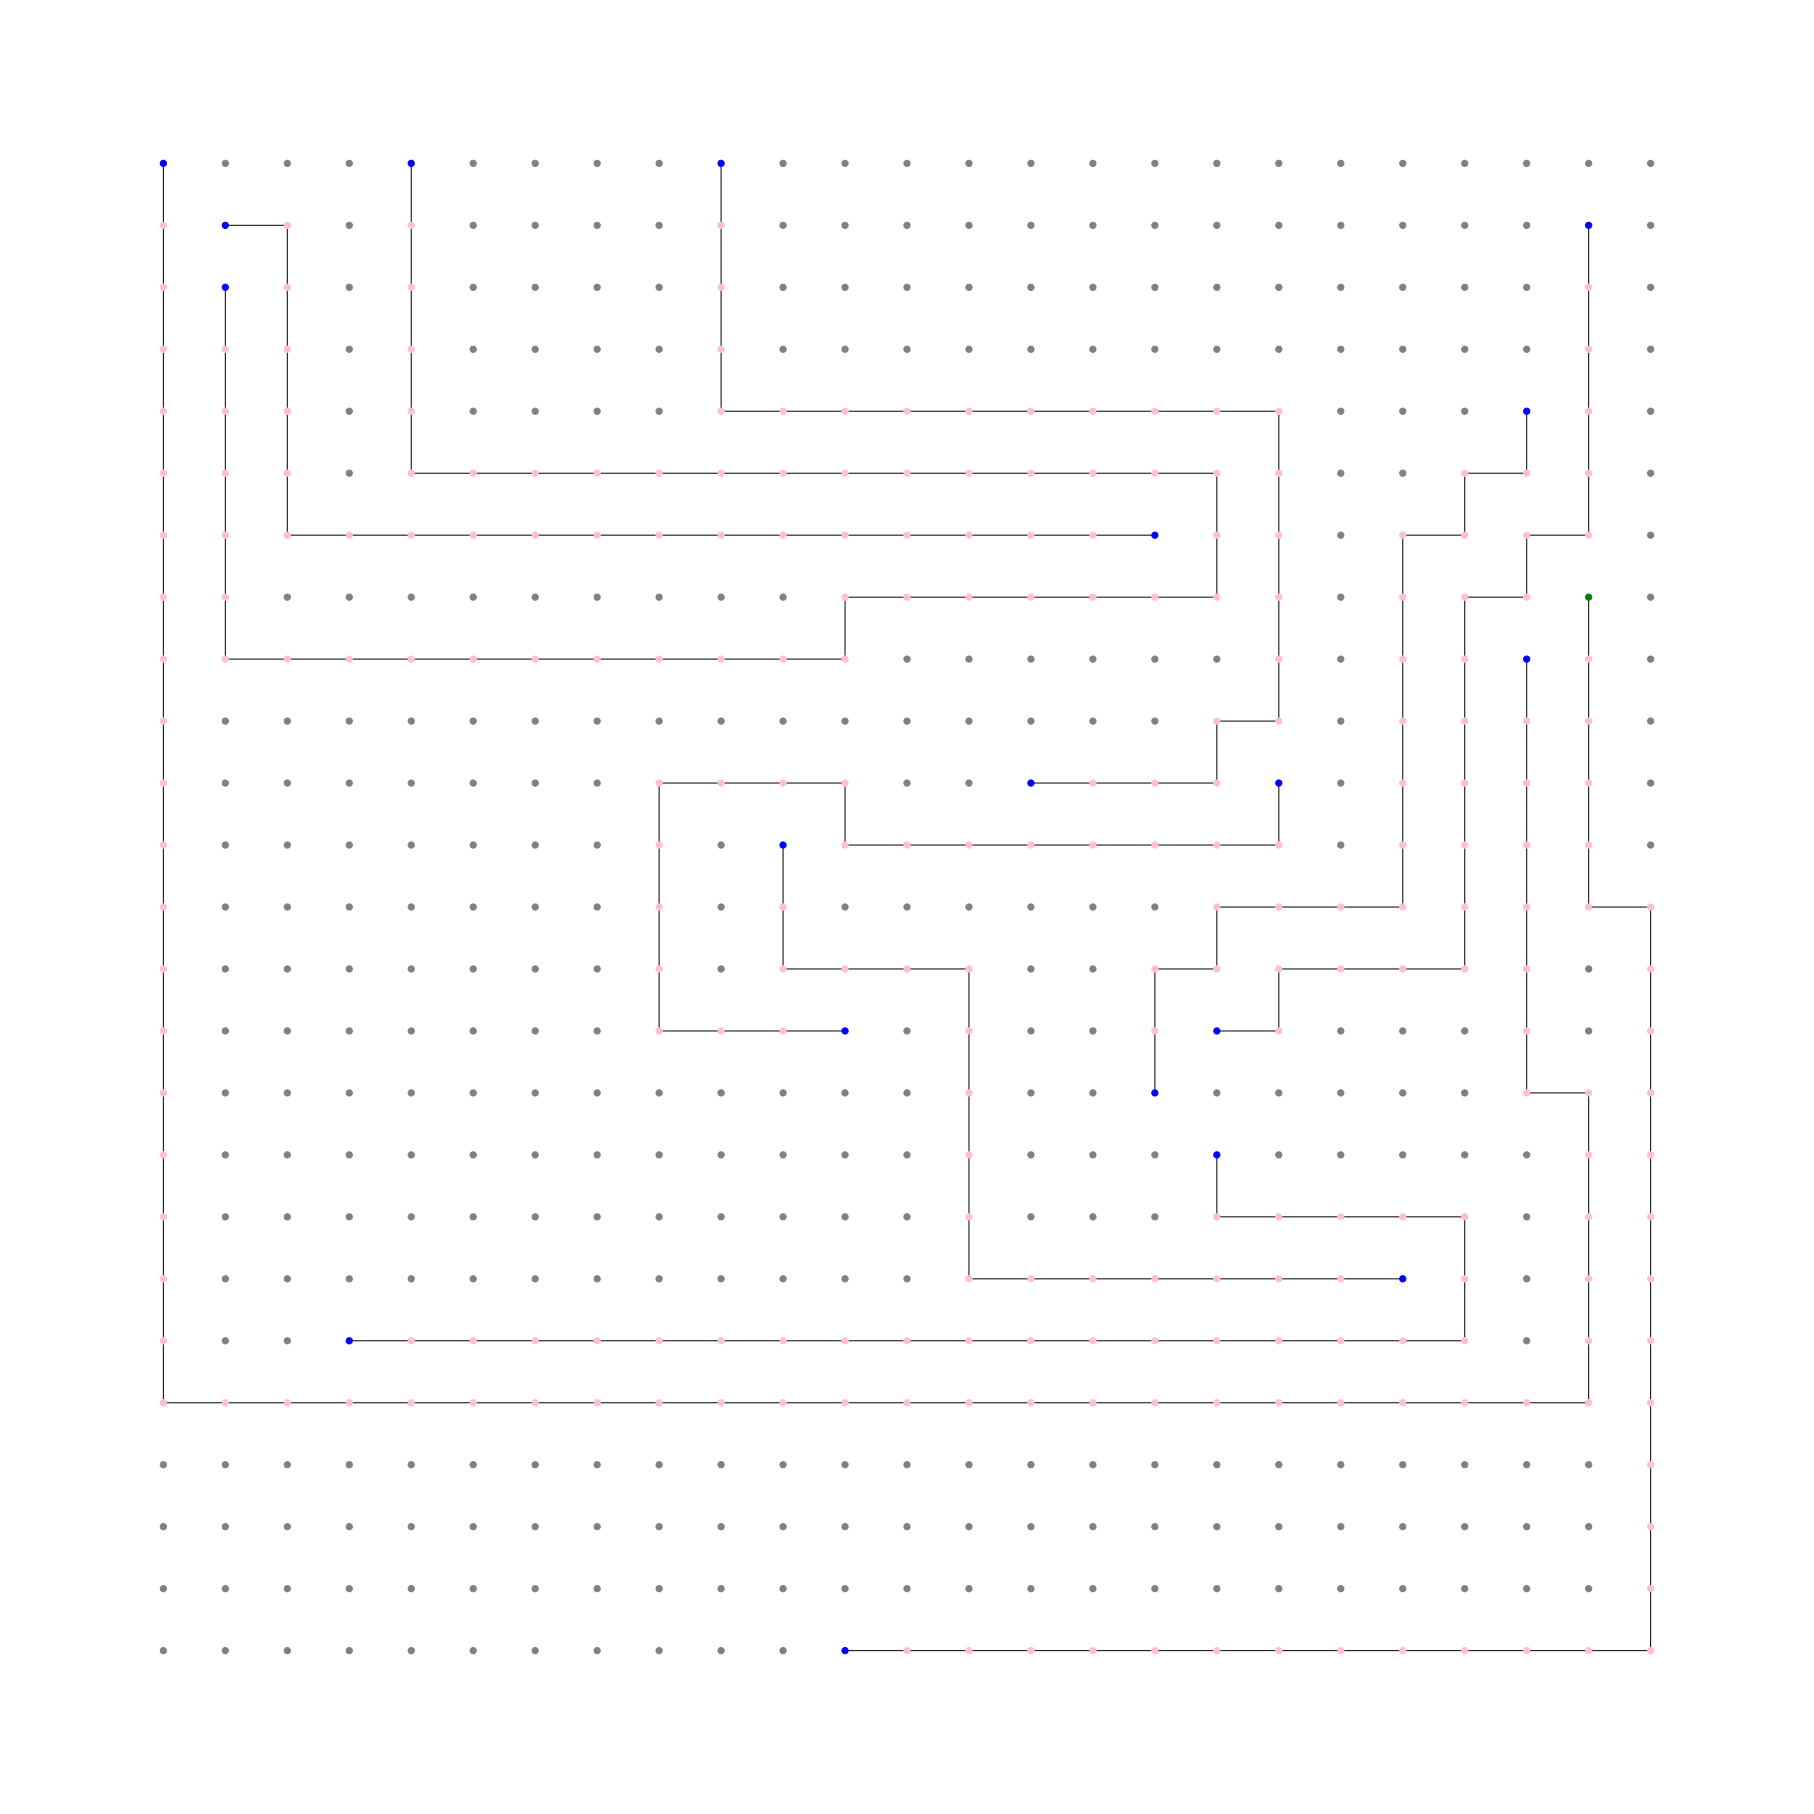

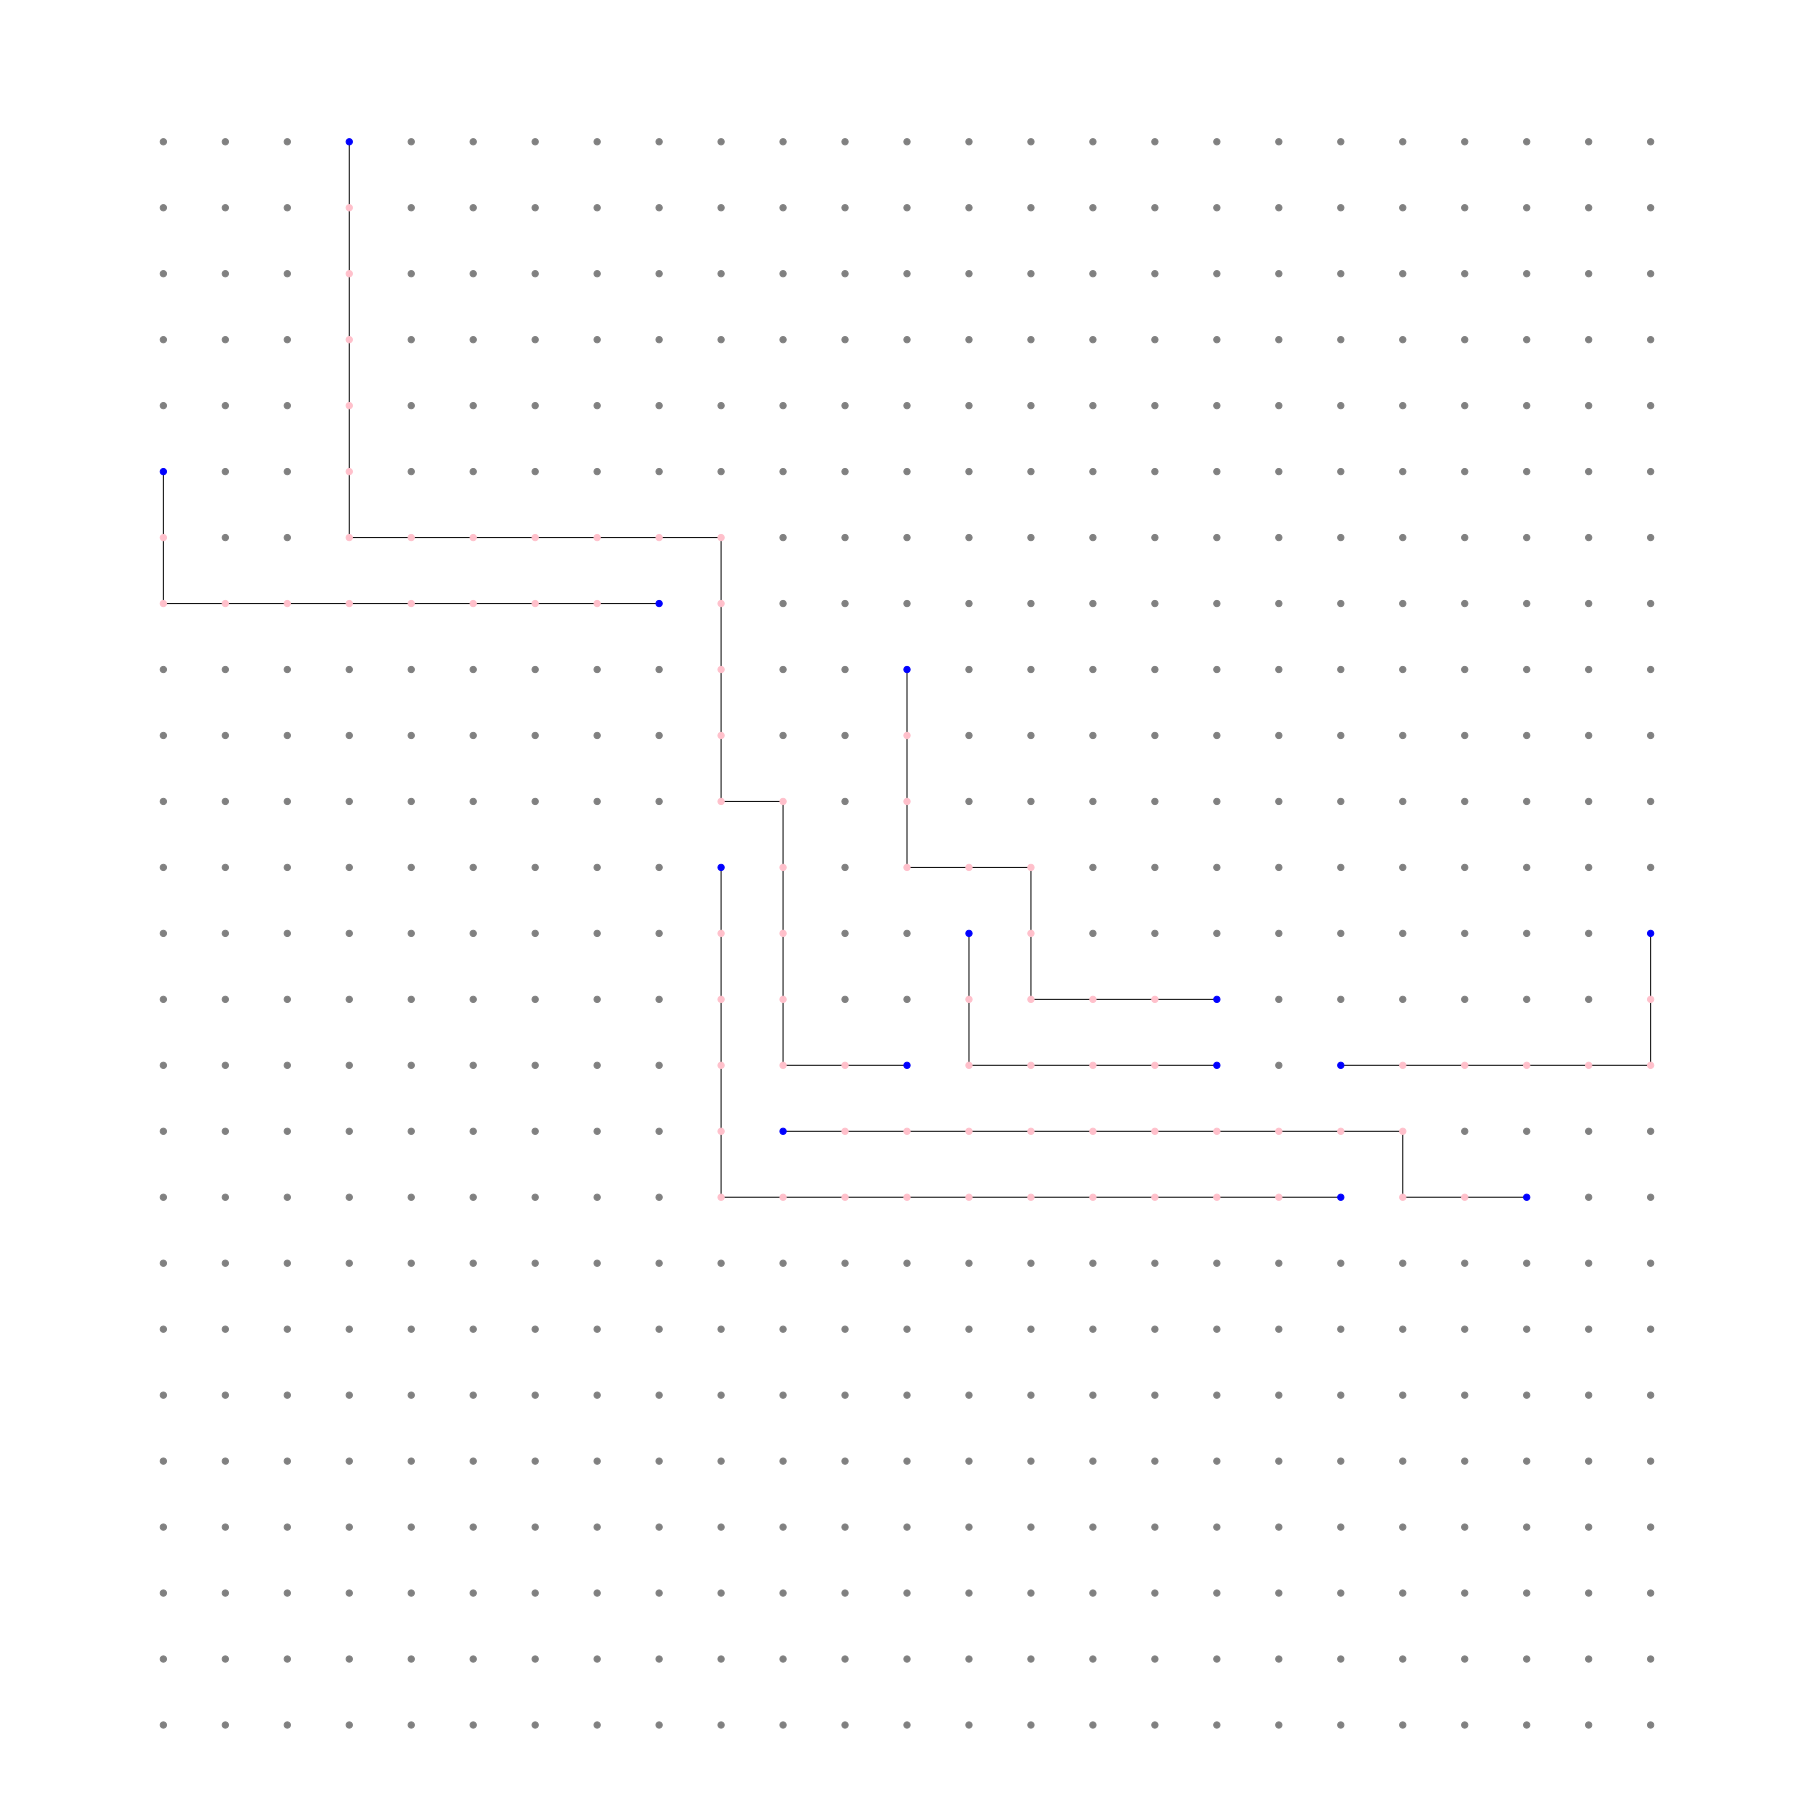

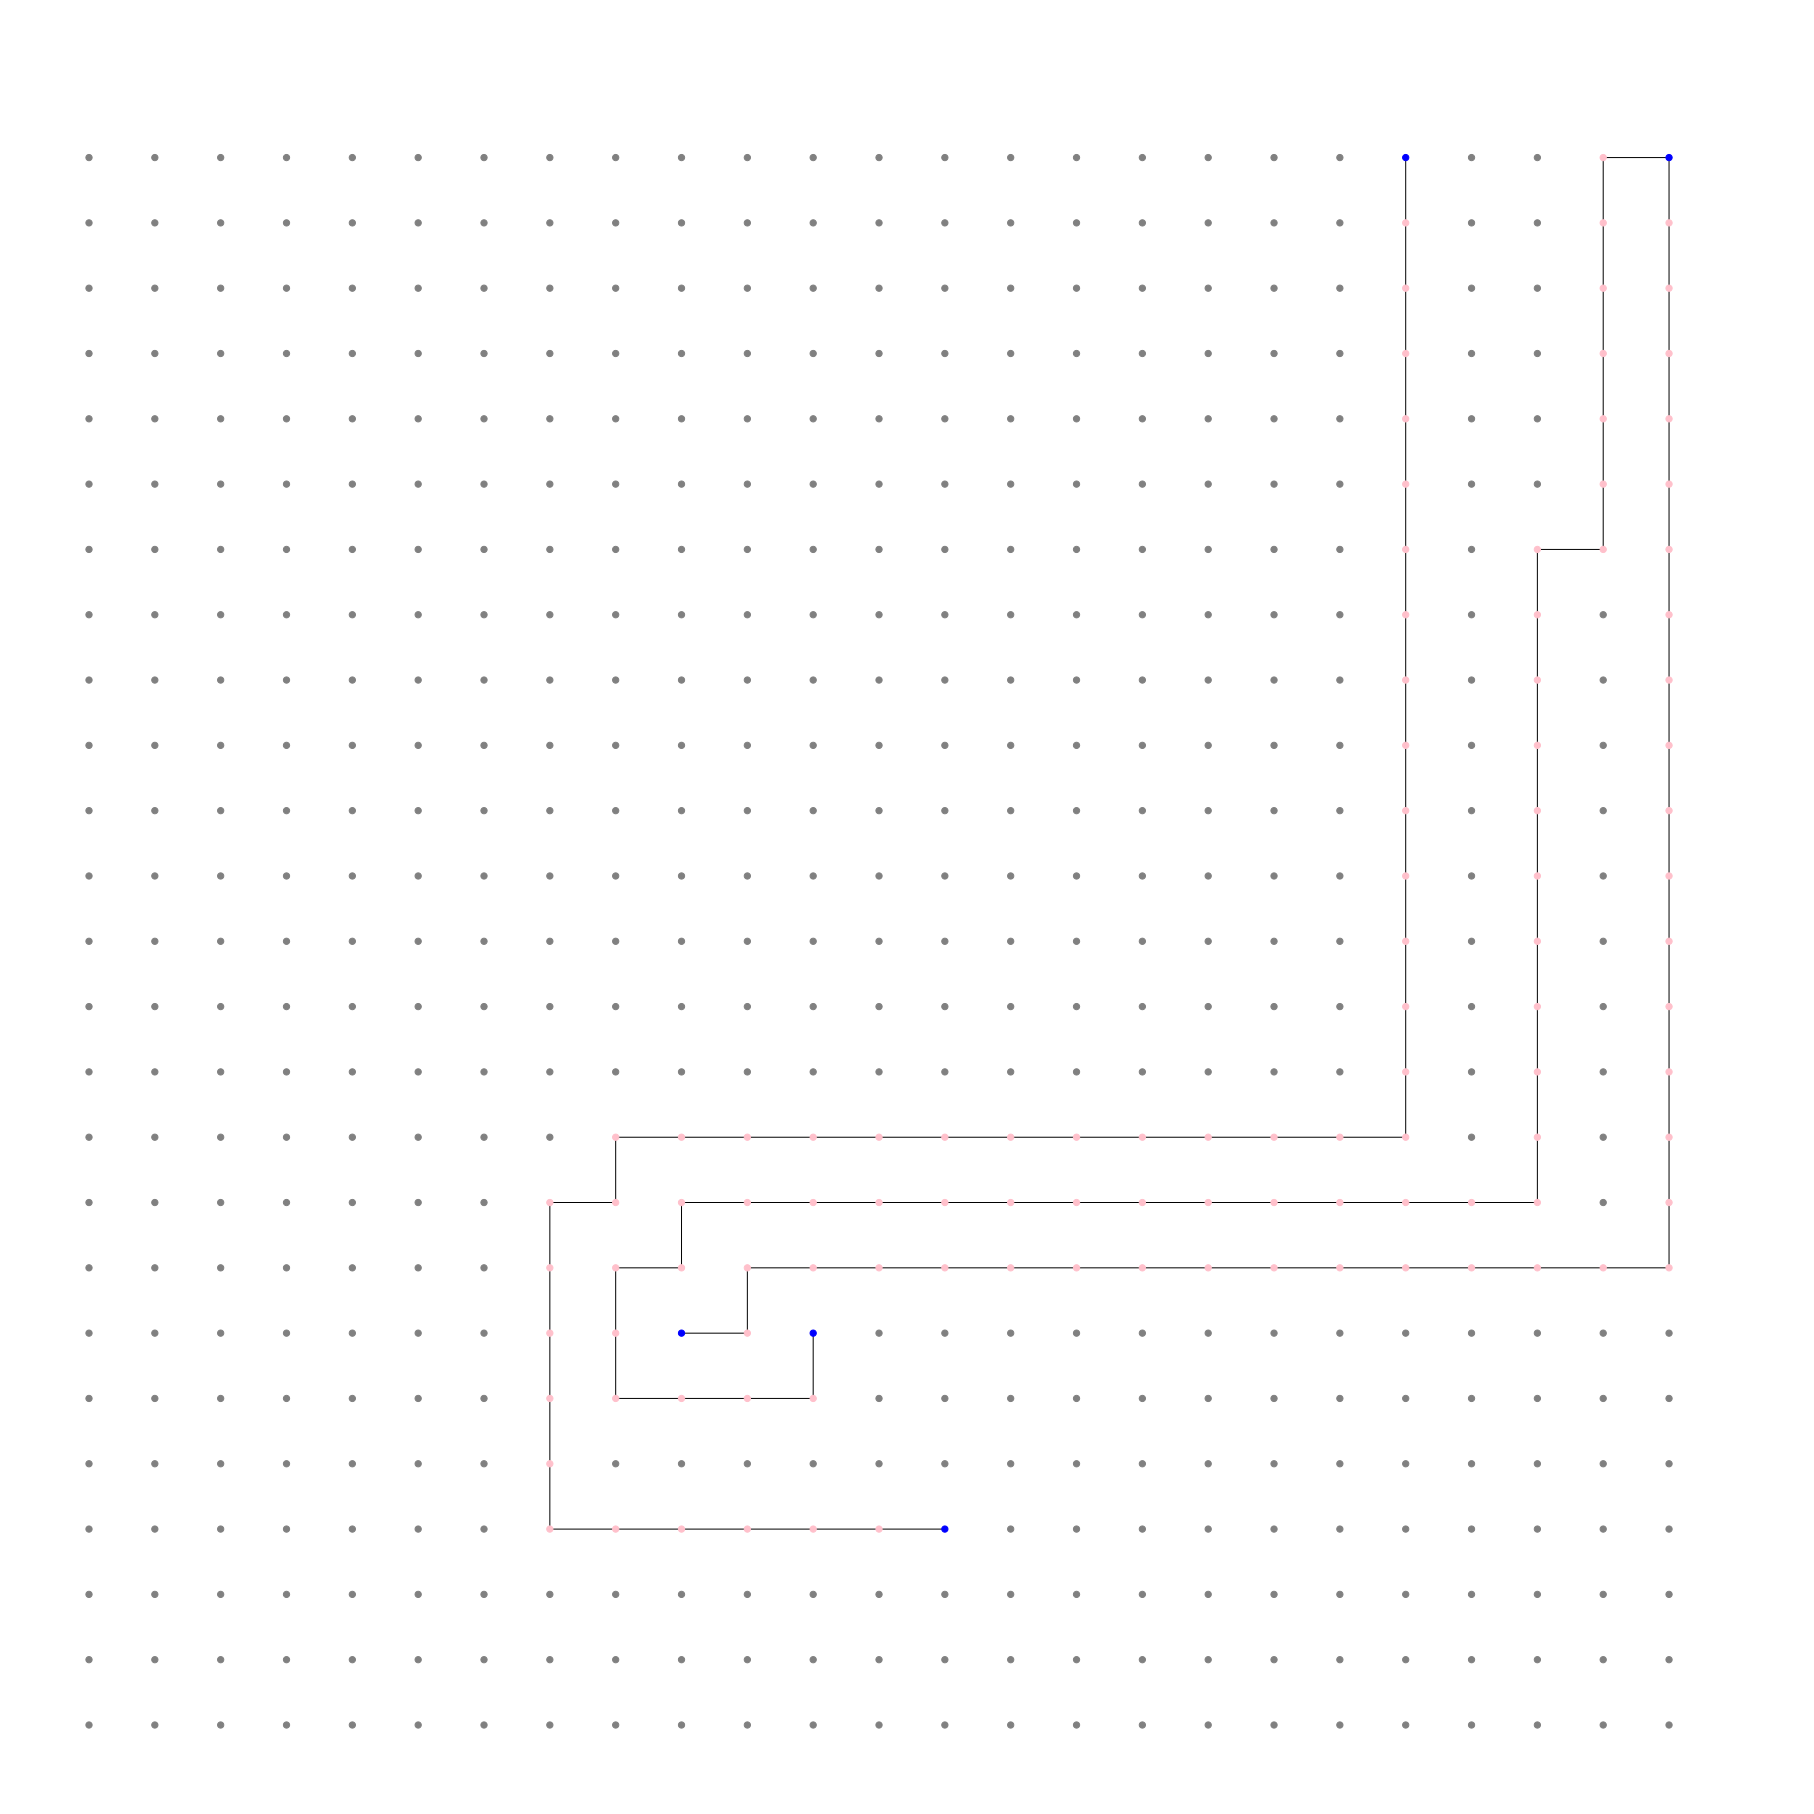

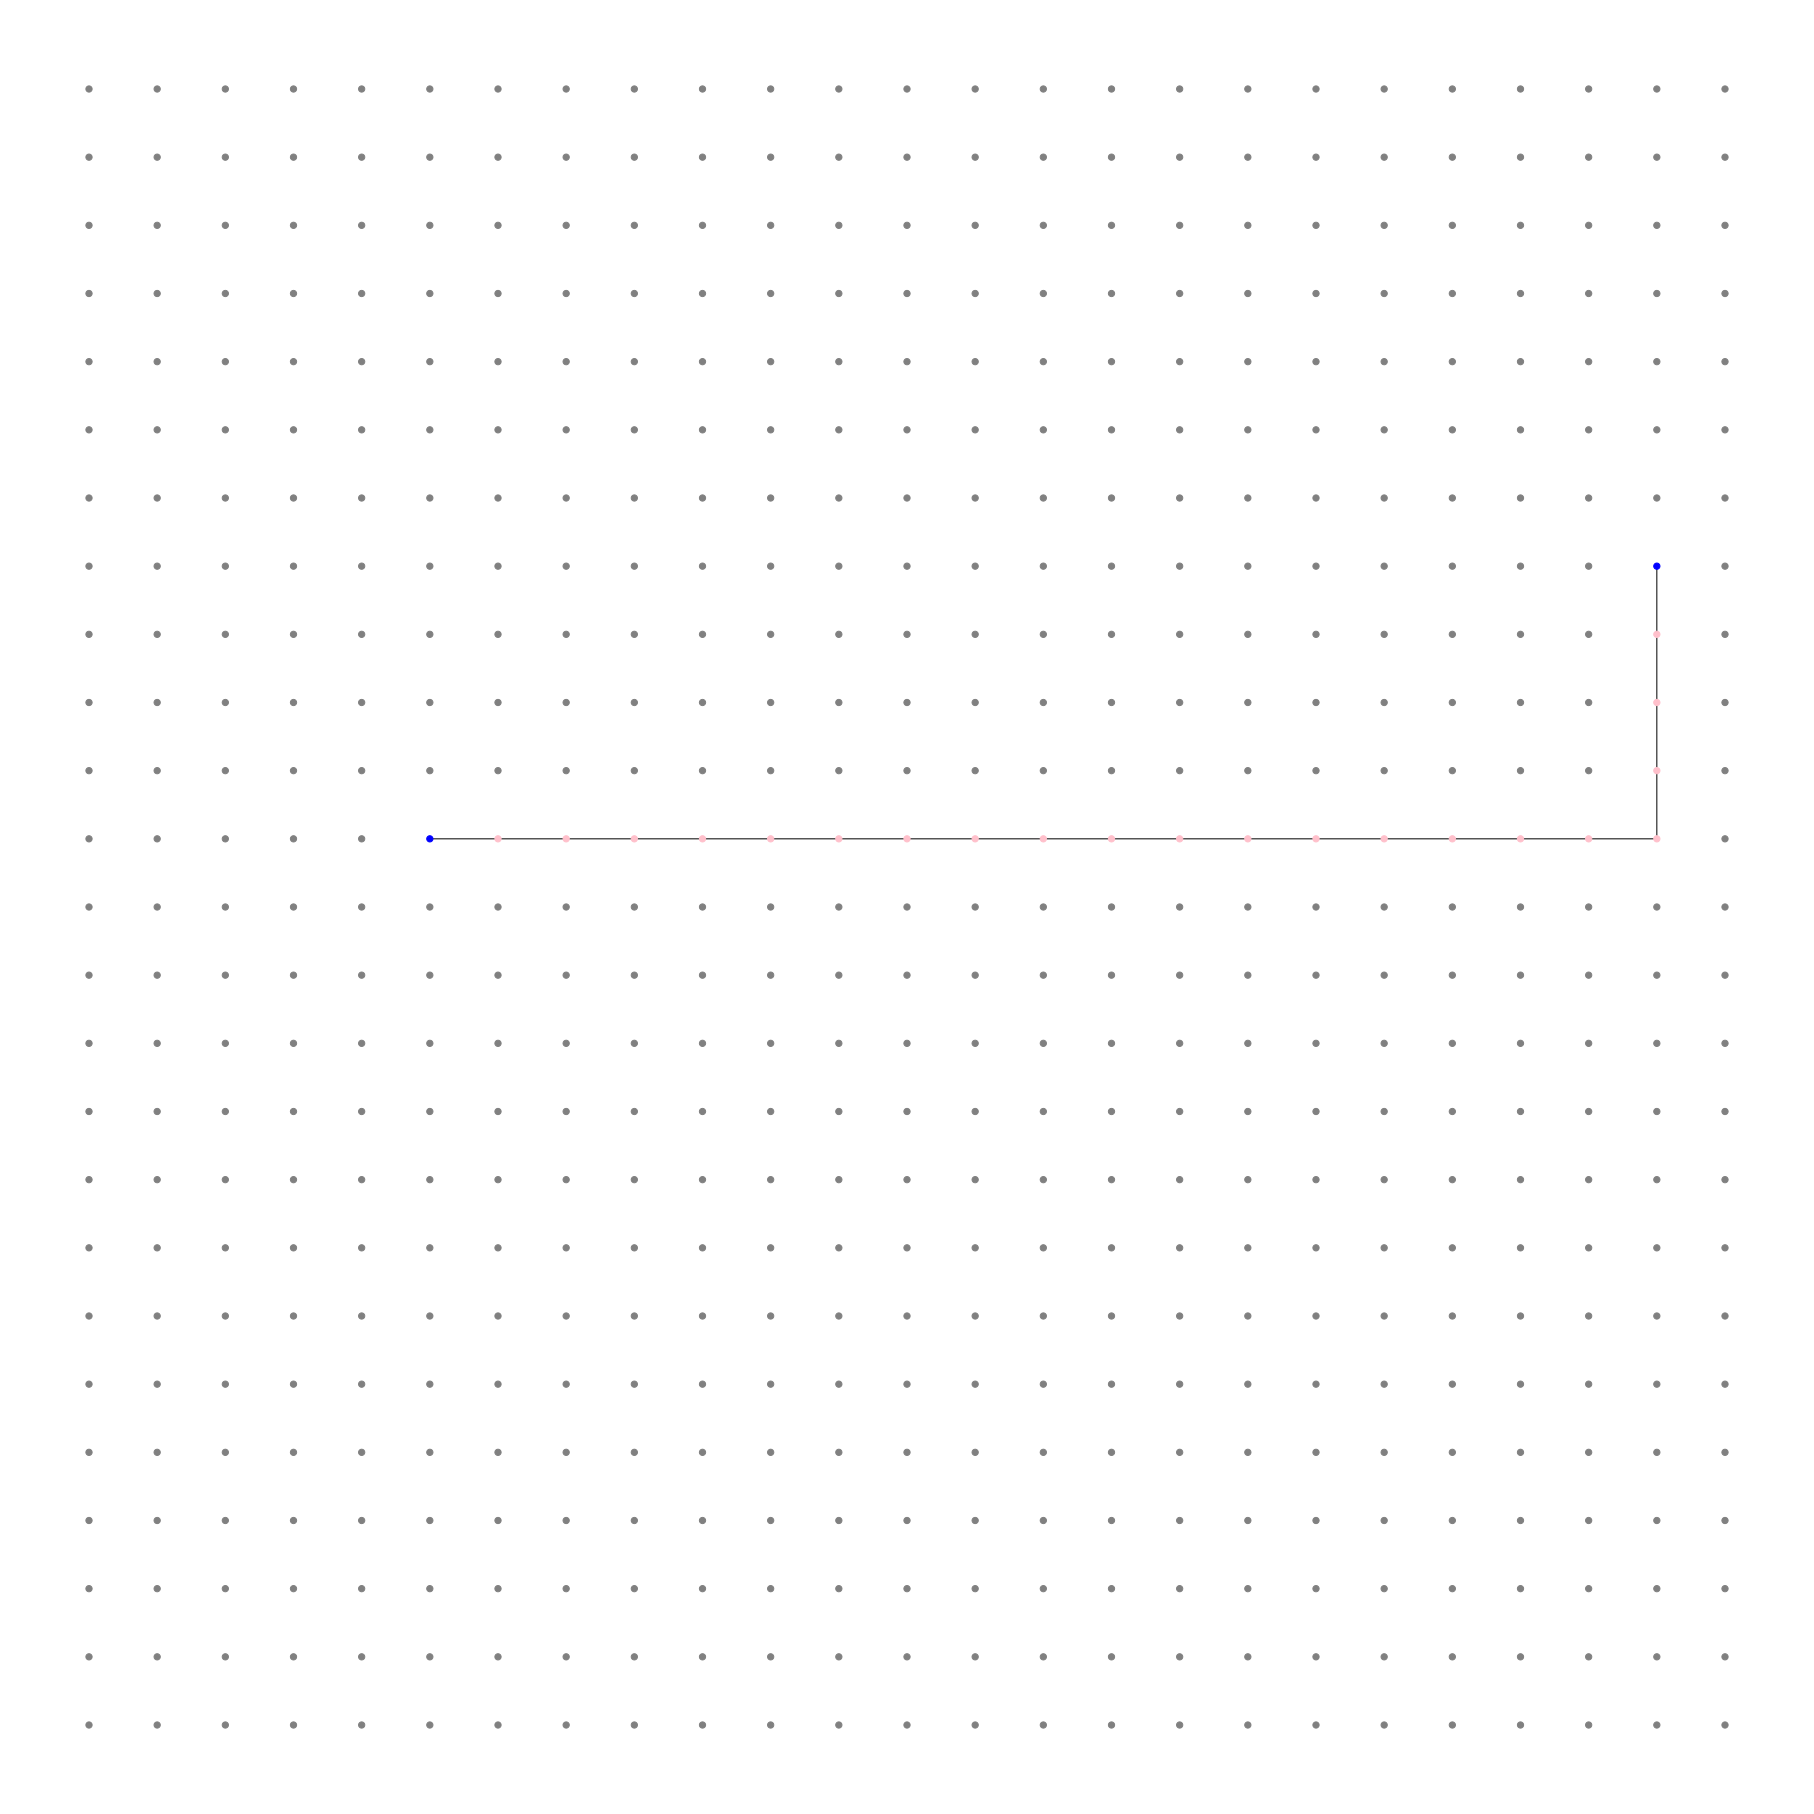

769 nodes
11 layers
fusion: 2549
connect qubits validation success!
begin to validate!
validate success!


In [1]:
from Fusion import *
from Graph_State import *
from Compact_Graph_Dynamic import *
from Compact_Graph_Dynamic_List import *
from Compact_Graph import *
from Validate import *
from Construct_Test_Circuit import *
from Determine_Dependency import *
from Partition import *
from Add_Round import *

NQubit = 20
Depth = 300
MaxDegree = 3
StarStructure = True
DynamicSchedule = False
def to_undirected(gs):
    undirected_graph = nx.Graph()
    for nnode in gs.nodes():
        undirected_graph.add_node(nnode)
        # if not Generalized_Flow_Flag:
        if not DynamicSchedule:
            undirected_graph.nodes[nnode]['layer'] = gs.nodes[nnode]['layer']
    for edge in gs.edges():
        if edge not in undirected_graph.edges():
            undirected_graph.add_edge(edge[0], edge[1])
            undirected_graph[edge[0]][edge[1]]['con_qubits'] = {}
            undirected_graph[edge[0]][edge[1]]['con_qubits'][edge[0]] = 0
            undirected_graph[edge[0]][edge[1]]['con_qubits'][edge[1]] = 0
    return undirected_graph

def main():
    # construct circuit
    # gates_list, qubits = generate_circuit(NQubit, Depth)
    gates_list, qubits = construct_qaoa(NQubit, 0.5)

    # generate graph state
    gs, input_nodes, colors = generate_graph_state(gates_list, qubits)
    
    if DynamicSchedule:
        # causal flow
        dgraph = determine_dependency(gs)
        # gs = schedule(gs, dgraph)
        # gs = partition(gs, input_nodes)
        # pos = nx.get_node_attributes(gs, 'pos')
        undirected_graph = to_undirected(gs)

        # # generalized flow
        # if Generalized_Flow_Flag:
        #     undirected_graph = generalized_flow(undirected_graph, input_nodes)
        #     labels = {node: str(undirected_graph.nodes[node]['layer']) for node in undirected_graph.nodes()}
        #     nx.draw(undirected_graph, pos = pos, labels = labels, node_size = 30, font_size = 10)


        # fusion
        fgraph, added_nodes = fusion_graph_dynamic(undirected_graph, MaxDegree, StarStructure)
        
        # add rounds
        # fgraph = add_round(fgraph, 1)
        
        # map and route
        if StarStructure:
            net_list = compact_graph_dynamic(fgraph, dgraph, MaxDegree)
        else:
            net_list = compact_graph_dynamic_list(fgraph, dgraph, MaxDegree)
    else:
        gs = partition(gs, input_nodes)
        undirected_graph = to_undirected(gs)
        fgraph, added_nodes = fusion_graph(undirected_graph, MaxDegree, StarStructure)
        fgraph = add_round(fgraph, 1)
        net_list = compact_graph(fgraph, MaxDegree)
    # show result
    fusions = 0
    for net in net_list:
        fusions += len(list(net.edges()))
    print("fusion:", fusions)
    if StarStructure:
        validate_con_qubits(net_list, MaxDegree)
        fgraph = validate(net_list, fgraph, MaxDegree)   
    return

if __name__ == '__main__':
    main()